Import Libraries

In [1]:
import os
import msoffcrypto
import pandas as pd
import numpy as np
from datetime import datetime as dt
from matplotlib import pyplot as plt
from scipy.interpolate import CubicSpline
from sklearn.linear_model import LinearRegression
import pmdarima as pm
from pmdarima import model_selection
import math
import pytz
import datetime

In [2]:
xls = pd.ExcelFile("RawData13.xlsx")
Factor_data = pd.read_excel(xls,'Factor')
Gold_data = pd.read_excel(xls,'GoldBar_Sale')

In [3]:
factor_col = Factor_data.columns[1:]

In [4]:
factor_col

Index(['(Inflation)', 'PTT_แก๊สโซฮอล์_95', 'PTT_แก๊สโซฮอล์_91', 'PTT_ดีเซล',
       'อัตราแลกเปลี่ยน_USD_THB', 'BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)',
       'SCB_ออมทรัพย์(อัตราดอกเบี้ย)', 'SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)',
       'SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)', 'SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)',
       'XAU_USD'],
      dtype='object')

In [5]:
for month in range(1,6):
    Factor_data[[i+f'_LAG_{month}' for i in factor_col]] = Factor_data[factor_col].shift(month)

In [7]:
# Factor_data[['LOG_'+i for i in factor_col]] = \
#     Factor_data[[i for i in factor_col]].apply(np.log)
for month in range(0,3):
    Factor_data[['LOG_'+i+f'_LAG_{month}' if month!=0 else 'LOG_'+i for i in factor_col]] = \
    Factor_data[[i+f'_LAG_{month}' if month!=0 else i for i in factor_col]].apply(np.log)

In [8]:
Factor_data.columns

Index(['Report Date', '(Inflation)', 'PTT_แก๊สโซฮอล์_95', 'PTT_แก๊สโซฮอล์_91',
       'PTT_ดีเซล', 'อัตราแลกเปลี่ยน_USD_THB',
       'BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)',
       'SCB_ออมทรัพย์(อัตราดอกเบี้ย)', 'SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)',
       'SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)', 'SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)',
       'XAU_USD', '(Inflation)_LAG_1', 'PTT_แก๊สโซฮอล์_95_LAG_1',
       'PTT_แก๊สโซฮอล์_91_LAG_1', 'PTT_ดีเซล_LAG_1',
       'อัตราแลกเปลี่ยน_USD_THB_LAG_1',
       'BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)_LAG_1',
       'SCB_ออมทรัพย์(อัตราดอกเบี้ย)_LAG_1',
       'SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)_LAG_1',
       'SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)_LAG_1',
       'SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)_LAG_1', 'XAU_USD_LAG_1',
       '(Inflation)_LAG_2', 'PTT_แก๊สโซฮอล์_95_LAG_2',
       'PTT_แก๊สโซฮอล์_91_LAG_2', 'PTT_ดีเซล_LAG_2',
       'อัตราแลกเปลี่ยน_USD_THB_LAG_2',
       'BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)_LAG_2',
       'SCB_ออมทรัพย์(อัตราดอกเบี้ย)_LAG_2'

In [9]:
# %change 1-12 Months
for month in range(1,6):
    Factor_data[['%CHANGE_'+i+f'_LAG_{month}' for i in factor_col]] = \
    (Factor_data[factor_col].values - Factor_data[[i+f'_LAG_{month}' for i in factor_col]].values)/(Factor_data[[i+f'_LAG_{month}' for i in factor_col]].values)

C:\Users\temp5\AppData\Local\Temp\ipykernel_10472\2617992307.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Factor_data[['%CHANGE_'+i+f'_LAG_{month}' for i in factor_col]] = \
C:\Users\temp5\AppData\Local\Temp\ipykernel_10472\2617992307.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Factor_data[['%CHANGE_'+i+f'_LAG_{month}' for i in factor_col]] = \
C:\Users\temp5\AppData\Local\Temp\ipykernel_10472\2617992307.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

In [12]:
# Factor_data.columns

In [13]:
Gold_Factor_data = \
                pd.merge(
                    Gold_data,
                    Factor_data,
                    left_on = 'Report Date',
                    right_on = 'Report Date',
                    how = 'left'
                )

In [14]:
Gold_Factor_data.replace([np.inf, -np.inf, np.nan],0,inplace=True)
# Gold_Factor_data.replace([np.inf, -np.inf],np.nan,inplace=True)
Gold_Factor_data = Gold_Factor_data.dropna(axis='columns')

In [15]:
Gold_Factor_data.columns

Index(['Report Date', 'GoldBar_Sale', '(Inflation)', 'PTT_แก๊สโซฮอล์_95',
       'PTT_แก๊สโซฮอล์_91', 'PTT_ดีเซล', 'อัตราแลกเปลี่ยน_USD_THB',
       'BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)',
       'SCB_ออมทรัพย์(อัตราดอกเบี้ย)', 'SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)',
       ...
       '%CHANGE_PTT_แก๊สโซฮอล์_95_LAG_5', '%CHANGE_PTT_แก๊สโซฮอล์_91_LAG_5',
       '%CHANGE_PTT_ดีเซล_LAG_5', '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_5',
       '%CHANGE_BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)_LAG_5',
       '%CHANGE_SCB_ออมทรัพย์(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_XAU_USD_LAG_5'],
      dtype='object', length=156)

In [16]:
Gold_Factor_data = Gold_Factor_data[Gold_Factor_data['Report Date'] >= '2021-01-31']
Gold_Factor_data = Gold_Factor_data[Gold_Factor_data['Report Date'] <= '2023-12-31']

In [17]:
Gold_Factor_data

,Report Date,GoldBar_Sale,(Inflation),PTT_แก๊สโซฮอล์_95,PTT_แก๊สโซฮอล์_91,PTT_ดีเซล,อัตราแลกเปลี่ยน_USD_THB,BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย),SCB_ออมทรัพย์(อัตราดอกเบี้ย),SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย),...,%CHANGE_PTT_แก๊สโซฮอล์_95_LAG_5,%CHANGE_PTT_แก๊สโซฮอล์_91_LAG_5,%CHANGE_PTT_ดีเซล_LAG_5,%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_5,%CHANGE_BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)_LAG_5,%CHANGE_SCB_ออมทรัพย์(อัตราดอกเบี้ย)_LAG_5,%CHANGE_SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)_LAG_5,%CHANGE_SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)_LAG_5,%CHANGE_SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)_LAG_5,%CHANGE_XAU_USD_LAG_5
120,2021-01-31,26250,0.21,24.25,23.98,25.09,29.86,0.50,0.25,0.375,...,0.089888,0.090992,0.125617,-0.038944,0.000000,0.0,0.000000,0.000000,0.000000,0.083258
121,2021-02-28,25350,0.04,26.05,25.78,26.99,30.47,0.50,0.25,0.370,...,0.197701,0.200186,0.267731,-0.035759,0.000000,0.0,-0.013333,-0.100000,-0.100000,0.137228
122,2021-03-31,25500,0.09,26.15,25.88,23.19,31.24,0.50,0.25,0.320,...,0.213457,0.216165,0.059388,0.003211,0.000000,0.0,-0.146667,-0.200000,-0.200000,0.065396
123,2021-04-30,26250,0.30,29.05,28.78,25.99,31.14,0.50,0.25,0.320,...,0.299776,0.303442,0.092476,0.028402,0.000000,0.0,-0.146667,-0.200000,-0.200000,0.068294
124,2021-05-31,28100,0.49,27.95,27.68,25.09,31.19,0.50,0.25,0.320,...,0.228571,0.231317,0.037205,0.038282,0.000000,0.0,-0.146667,-0.200000,-0.200000,-0.002665
125,2021-06-30,26900,0.52,28.75,28.48,25.79,32.02,0.50,0.25,0.320,...,0.185567,0.187656,0.027900,0.072338,0.000000,0.0,-0.146667,-0.200000,-0.200000,0.034085
126,2021-07-31,28300,0.14,29.55,29.28,26.09,32.89,0.50,0.25,0.320,...,0.134357,0.135764,-0.033346,0.079422,0.000000,0.0,-0.135135,-0.111111,-0.111111,-0.063292
127,2021-08-30,27950,0.07,29.25,28.98,25.79,32.22,0.50,0.25,0.320,...,0.118547,0.119784,0.112117,0.031370,0.000000,0.0,0.000000,0.000000,0.000000,-0.036580
128,2021-09-30,27850,0.19,30.75,30.48,27.69,33.67,0.50,0.25,0.320,...,0.058520,0.059069,0.065410,0.081246,0.000000,0.0,0.000000,0.000000,0.000000,-0.030435
129,2021-10-31,28200,0.21,32.55,32.28,29.69,33.29,0.50,0.25,0.320,...,0.164580,0.166185,0.183340,0.067329,0.000000,0.0,0.000000,0.000000,0.000000,0.030811


In [18]:
Gold_Factor_data['LOGIT'] = np.log(Gold_Factor_data['GoldBar_Sale'].values)
Gold_Factor_data['LOGIT'].replace([np.inf, -np.inf, np.nan],0,inplace=True)

C:\Users\temp5\AppData\Local\Temp\ipykernel_10472\3363949668.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Gold_Factor_data['LOGIT'].replace([np.inf, -np.inf, np.nan],0,inplace=True)


In [19]:
Factor_data.columns

Index(['Report Date', '(Inflation)', 'PTT_แก๊สโซฮอล์_95', 'PTT_แก๊สโซฮอล์_91',
       'PTT_ดีเซล', 'อัตราแลกเปลี่ยน_USD_THB',
       'BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)',
       'SCB_ออมทรัพย์(อัตราดอกเบี้ย)', 'SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)',
       'SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)',
       ...
       '%CHANGE_PTT_แก๊สโซฮอล์_95_LAG_5', '%CHANGE_PTT_แก๊สโซฮอล์_91_LAG_5',
       '%CHANGE_PTT_ดีเซล_LAG_5', '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_5',
       '%CHANGE_BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)_LAG_5',
       '%CHANGE_SCB_ออมทรัพย์(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_XAU_USD_LAG_5'],
      dtype='object', length=155)

In [20]:
Gold_Factor_data['LOGIT']

120    10.175421
121    10.140534
122    10.146434
123    10.175421
124    10.243525
125    10.199882
126    10.250617
127    10.238172
128    10.234588
129    10.247077
130    10.262909
131    10.262909
132    10.255903
133    10.280210
134    10.327120
135    10.335270
136    10.308953
137    10.322198
138    10.315597
139    10.300584
140    10.288750
141    10.297217
142    10.298902
143    10.297217
144    10.307285
145    10.308953
146    10.367222
147    10.375052
148    10.373491
149    10.378168
150    10.367222
151    10.373491
152    10.393600
153    10.439981
154    10.422281
155    10.423768
Name: LOGIT, dtype: float64

In [21]:
Gold_Factor_data.to_excel("LAG_RESULT.xlsx")

เลือกตัวแปรที่สนใจ และเกี่ยวข้องกับทองคำ

In [22]:
import statsmodels.api as sm
from statsmodels.compat import lzip
from statsmodels.tsa.stattools import adfuller
main_Factor_list = factor_col
# Factor_list = Gold_Factor_data.drop(columns = ['GoldBar_Sale'] ).columns
# Factor_list = Gold_Factor_data.drop(columns = ['Report Date','GoldBar_Sale','LOGIT']).columns
Factor_list = Gold_Factor_data.drop(columns = ['Report Date','GoldBar_Sale','LOGIT']).columns
All_result_table = pd.DataFrame()
All_result_table_best = pd.DataFrame()

for ix , temp_factor_group in enumerate(main_Factor_list,1):
    Factor_group = [i for i in Factor_list if temp_factor_group in i]
    r2_list = []
    # print(ix , " " , temp_factor_group , " " , Factor_group)
    # print(Factor_group)
    temp_result_table = pd.DataFrame()
    for temp_factor in Factor_group:
        X_train = np.array(Gold_Factor_data[temp_factor].values , dtype=float)
        y_train = np.array(Gold_Factor_data['LOGIT'].values , dtype=float)
        # y_train = np.array(Gold_Factor_data['GoldBar_Sale'].values , dtype=float)
        
        X_train_1 = X_train.reshape(-1,1)
        y_train_1 = y_train.reshape(-1,1)

        # test stationary test 10%
        adf = adfuller(X_train)[1]
        adf_result = 'PASS' if adfuller(X_train)[1] <= 0.4 else 'FAIL'

        #Regression
        linear_model = LinearRegression()
        linear_model.fit(X_train_1 , y_train_1)

        X_train = sm.add_constant(X_train)
        reg = sm.OLS(y_train , X_train).fit()
        sign = '+' if linear_model.coef_ > 0 else '-'

        r2_list.append((temp_factor,reg.rsquared,sign,adf,adf_result))
        # print(r2_list)

    temp_result_table['Factor'] = np.array(r2_list)[:,0]
    temp_result_table['r2'] = np.array(r2_list)[:,1]
    temp_result_table['sign'] = np.array(r2_list)[:,2]
    temp_result_table['adf'] = np.array(r2_list)[:,3]
    temp_result_table['adf_result'] = np.array(r2_list)[:,4]

    temp_result_table_sort = temp_result_table.sort_values(['adf_result','r2'], ascending = [False,False]).reset_index(drop=True)

    if ix == 1:
        All_result_table = temp_result_table
        All_result_table_best = temp_result_table_sort.head(1)
    else:
        All_result_table = pd.concat([All_result_table,temp_result_table], ignore_index = True)
        All_result_table_best = pd.concat([All_result_table,temp_result_table_sort.head(1)], ignore_index = True)
All_result_table

,Factor,r2,sign,adf,adf_result
0,(Inflation),0.09024038469496243,+,0.09684395234603099,PASS
1,(Inflation)_LAG_1,0.11791620029287686,+,0.12055063203130434,PASS
2,(Inflation)_LAG_2,0.14962149634179067,+,0.10688753090534808,PASS
3,(Inflation)_LAG_3,0.18743000101424623,+,0.09771271094790362,PASS
4,(Inflation)_LAG_4,0.2486459089274532,+,0.08650303272680737,PASS
...,...,...,...,...,...
149,%CHANGE_XAU_USD_LAG_1,0.02095223261394119,+,1.165999871275545e-09,PASS
150,%CHANGE_XAU_USD_LAG_2,0.012029775979757074,+,0.0667288052434516,PASS
151,%CHANGE_XAU_USD_LAG_3,1.0254635562256809e-05,-,0.23630168304622828,PASS
152,%CHANGE_XAU_USD_LAG_4,0.0009347248023651167,-,0.23025645957823104,PASS


In [23]:
Factor_list

Index(['(Inflation)', 'PTT_แก๊สโซฮอล์_95', 'PTT_แก๊สโซฮอล์_91', 'PTT_ดีเซล',
       'อัตราแลกเปลี่ยน_USD_THB', 'BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)',
       'SCB_ออมทรัพย์(อัตราดอกเบี้ย)', 'SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)',
       'SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)', 'SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)',
       ...
       '%CHANGE_PTT_แก๊สโซฮอล์_95_LAG_5', '%CHANGE_PTT_แก๊สโซฮอล์_91_LAG_5',
       '%CHANGE_PTT_ดีเซล_LAG_5', '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_5',
       '%CHANGE_BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)_LAG_5',
       '%CHANGE_SCB_ออมทรัพย์(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_XAU_USD_LAG_5'],
      dtype='object', length=154)

In [24]:
All_result_table[All_result_table['adf_result'] == 'PASS']

,Factor,r2,sign,adf,adf_result
0,(Inflation),0.09024038469496243,+,0.09684395234603099,PASS
1,(Inflation)_LAG_1,0.11791620029287686,+,0.12055063203130434,PASS
2,(Inflation)_LAG_2,0.14962149634179067,+,0.10688753090534808,PASS
3,(Inflation)_LAG_3,0.18743000101424623,+,0.09771271094790362,PASS
4,(Inflation)_LAG_4,0.2486459089274532,+,0.08650303272680737,PASS
...,...,...,...,...,...
149,%CHANGE_XAU_USD_LAG_1,0.02095223261394119,+,1.165999871275545e-09,PASS
150,%CHANGE_XAU_USD_LAG_2,0.012029775979757074,+,0.0667288052434516,PASS
151,%CHANGE_XAU_USD_LAG_3,1.0254635562256809e-05,-,0.23630168304622828,PASS
152,%CHANGE_XAU_USD_LAG_4,0.0009347248023651167,-,0.23025645957823104,PASS


In [25]:
Pass_Factor_list = All_result_table[All_result_table['adf_result'] == 'PASS']
Pass_Factor_list.to_excel("ADF_RESULT_PASS.xlsx")

In [26]:
Pass_Factor_list = Pass_Factor_list['Factor']

Overall Model Performance

In [73]:
from itertools import combinations
# comb_list = [i for i in combinations(Pass_Factor_list , 3)] + [i for i in combinations(Pass_Factor_list, 2)]
comb_list = [i for i in combinations(Pass_Factor_list , 3)]
# comb_list = [i for i in combinations(Pass_Stat_list['FACTOR_1'], 2)]
len(comb_list)
# 2 fac
#5000 = 2 min
#2346 = 50 sec
#30856 = 14 min
#4186 = 1.34 min/sec
#9453 = 3.32 min/sec
#17020 = 6.52 min/sec # 7.45.39 min/sec/msec
# 1 fac
#185 = 12ms
# new 3 fac
# 11480 = 5 min
# 2925 =1 min 10s
# new 4 fac
# 17550 = 9 mins 
# new 3 fac
# new 3 fac add %change
# 27720 = 12min
# 64824 = 51 min 39 sec

64824

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import anderson as AD
from statsmodels.stats.outliers_influence import variance_inflation_factor

all_stats_results = pd.DataFrame()

# y_train = np.array(Gold_Factor_data['GoldBar_Sale'].values , dtype=float)
y_train = np.array(Gold_Factor_data['LOGIT'].values , dtype=float)

for out_index , comb in enumerate(comb_list,1):
    selected_Factor = list(comb)
    X_train = np.array(Gold_Factor_data[selected_Factor].values , dtype = float)

    linear_model = LinearRegression()
    linear_model.fit(X_train , y_train)

    X_train = sm.add_constant(X_train)
    reg = sm.OLS(y_train , X_train).fit()

    X_train = X_train[:,1:]
    y_pred = linear_model.predict(X_train)

    stats_results = pd.DataFrame()
    stats_results[[f'FACTOR_{i+1}' for i in range(len(selected_Factor))]] = np.array([selected_Factor])

    coeff_result = reg.summary2().tables[1].iloc[:,:1].transpose().reset_index(drop=True)
    # for i in ['const','x1']:
    for i in ['const','x1','x2','x3']:
        if i in coeff_result.columns:
            stats_results[i] = coeff_result[i]
        else:
            stats_results[i] = None
    # P-Value
    stats_results[['intercept_p_value'] + [f'FACTOR_{i+1}_p_value' for i in range(len(selected_Factor))]] = reg.pvalues
    # ADJ Rsq
    r2 = r2_score(y_train,y_pred)
    n , p = X_train.shape
    adj_r2 = 1 - (( 1 - r2 ) * (n - 1) / (n - p - 1))
    stats_results['r2'] = r2
    stats_results['adj_r2'] = adj_r2
    # F stats
    stats_results['Probability of F-Stats'] = reg.summary2().tables[0][3].astype(float)[5]
    # Anderson Darling
    stats_results['AD'] = AD(reg.resid , dist='norm')[0]
    stats_results['AD_criteria'] = [{i:j for i , j in zip(AD( reg.resid , dist='norm')[2],
                                                         AD( reg.resid , dist='norm')[1]
                                                         )}]
    stats_results['AD_criteria_0.05'] = AD( reg.resid , dist='norm')[1][2:3]
    # Breusch-Pagan
    name_stats = ['Lagrange multiplier statistic','p-value','f-value','f p-value']
    test = sm.stats.het_breuschpagan(reg.resid , reg.model.exog )
    stats_results['BP_pvalues'] = lzip(name_stats , test )[1][1]
    # Durbin Watson
    stats_results['Durbin_Watson'] = sm.stats.durbin_watson(reg.resid)
    # VIF 
    VIF_values = [variance_inflation_factor(Gold_Factor_data[selected_Factor].values , i) for i in range(len(selected_Factor))]

    for in_index , i in enumerate(selected_Factor , 0 ):
        stats_results[f'VIF_Factor_{in_index+1}'] = VIF_values[in_index]
    if out_index == 1:
        all_stats_results = stats_results
    else:
        all_stats_results = pd.concat([all_stats_results, stats_results], axis = 0).reset_index(drop=True)
all_stats_results = all_stats_results.sort_values('adj_r2', ascending = False)

In [43]:
# Pass_Stat_list = pd.read_excel("Pass_Stat_list 3 factor Pass GoldBar_Sales v2.xlsx")
all_stats_results = pd.read_excel("Pass_Stat_list 3 factor Pass GoldBar_Sales v2.xlsx")

In [44]:
Pass_Stat_list = all_stats_results

In [45]:
#Adj Stats in factor to interesting
Pass_Stat_list = all_stats_results[all_stats_results['r2'] >= 0.5]
Pass_Stat_list = all_stats_results[all_stats_results['adj_r2'] >= 0.5]
Pass_Stat_list = Pass_Stat_list[Pass_Stat_list['Probability of F-Stats'] <= 0.5]
Pass_Stat_list = Pass_Stat_list[Pass_Stat_list['AD'] < Pass_Stat_list['AD_criteria_0.05']]
Pass_Stat_list = Pass_Stat_list[Pass_Stat_list['BP_pvalues'] > 0.05]
Pass_Stat_list = Pass_Stat_list[Pass_Stat_list['Durbin_Watson'] >= 1] 
Pass_Stat_list = Pass_Stat_list[Pass_Stat_list['VIF_Factor_1'] <= 5]
Pass_Stat_list = Pass_Stat_list[Pass_Stat_list['VIF_Factor_2'] <= 5]
Pass_Stat_list = Pass_Stat_list[Pass_Stat_list['VIF_Factor_3'] <= 5]
# Pass_Stat_list = Pass_Stat_list[Pass_Stat_list['VIF_Factor_4'] <= 5]
# Pass_Stat_list = Pass_Stat_list[(Pass_Stat_list['VIF_Factor_3'] <= 5 | (Pass_Stat_list['VIF_Factor_3'].isna()))]

In [46]:
# Pass_Stat_list['adj_r2'].max()
# Pass_Stat_list[Pass_Stat_list['adj_r2'].values == Pass_Stat_list['adj_r2'].max()]
# Pass_Stat_list.describe()
Pass_Stat_list[['FACTOR_1','FACTOR_2','FACTOR_3','const','x1','x2','x3','r2','adj_r2','AD','AD_criteria_0.05','BP_pvalues','Durbin_Watson','Probability of F-Stats','VIF_Factor_1','VIF_Factor_2','VIF_Factor_3']]
# Pass_Stat_list[['FACTOR_1','FACTOR_2','FACTOR_3','const','x1','x2','x3','r2','adj_r2','Durbin_Watson','Probability of F-Stats']]



,FACTOR_1,FACTOR_2,FACTOR_3,const,x1,x2,x3,r2,adj_r2,AD,AD_criteria_0.05,BP_pvalues,Durbin_Watson,Probability of F-Stats,VIF_Factor_1,VIF_Factor_2,VIF_Factor_3
0,(Inflation),LOG_PTT_แก๊สโซฮอล์_95_LAG_2,%CHANGE_PTT_ดีเซล_LAG_5,9.006225,-0.015674,0.378930,-0.330662,0.900748,0.891443,0.636898,0.721,0.075319,1.910884,3.900000e-16,2.643735,2.787422,1.218880
1,(Inflation),LOG_PTT_แก๊สโซฮอล์_91_LAG_2,%CHANGE_PTT_ดีเซล_LAG_5,9.020769,-0.015672,0.375664,-0.330415,0.900701,0.891392,0.633474,0.721,0.074156,1.908880,3.930000e-16,2.645969,2.789333,1.218698
2,PTT_แก๊สโซฮอล์_95_LAG_3,%CHANGE_PTT_ดีเซล_LAG_5,%CHANGE_BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)...,9.979587,0.010597,-0.428315,-0.061883,0.900697,0.891387,0.396176,0.721,0.464962,1.689690,3.930000e-16,2.030136,1.239380,1.731466
3,PTT_แก๊สโซฮอล์_91_LAG_3,%CHANGE_PTT_ดีเซล_LAG_5,%CHANGE_BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)...,9.982448,0.010597,-0.428315,-0.061883,0.900697,0.891387,0.396176,0.721,0.464962,1.689690,3.930000e-16,2.031487,1.238970,1.733203
4,PTT_แก๊สโซฮอล์_91_LAG_3,%CHANGE_PTT_ดีเซล_LAG_5,%CHANGE_BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)...,9.965456,0.010960,-0.370510,-0.113300,0.898575,0.889067,0.156043,0.721,0.273116,1.596314,5.510000e-16,1.632493,1.183407,1.463513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302,(Inflation)_LAG_2,LOG_PTT_ดีเซล_LAG_2,%CHANGE_XAU_USD_LAG_1,7.916341,-0.042152,0.717016,0.089522,0.574407,0.534508,0.179107,0.721,0.238608,1.063854,4.140000e-06,2.549210,2.626163,1.049295
1303,(Inflation)_LAG_2,%CHANGE_PTT_แก๊สโซฮอล์_91_LAG_5,LOG_PTT_ดีเซล_LAG_2,7.797220,-0.043293,0.037001,0.751888,0.573425,0.533433,0.191946,0.721,0.173266,1.025797,4.290000e-06,3.567201,1.866208,4.689985
1304,(Inflation)_LAG_2,LOG_PTT_ดีเซล_LAG_2,%CHANGE_XAU_USD_LAG_3,7.860463,-0.044138,0.734089,0.046648,0.572747,0.532693,0.153949,0.721,0.206066,1.019865,4.400000e-06,2.535462,2.682588,1.164366
1305,(Inflation),LOG_PTT_ดีเซล_LAG_2,%CHANGE_XAU_USD_LAG_1,8.240746,-0.033337,0.618036,0.183395,0.569204,0.528817,0.200502,0.721,0.387684,1.030203,5.010000e-06,2.620252,2.643311,1.044697


In [47]:
Pass_Stat_list

,FACTOR_1,FACTOR_2,FACTOR_3,const,x1,x2,x3,intercept_p_value,FACTOR_1_p_value,FACTOR_2_p_value,...,adj_r2,Probability of F-Stats,AD,AD_criteria,AD_criteria_0.05,BP_pvalues,Durbin_Watson,VIF_Factor_1,VIF_Factor_2,VIF_Factor_3
0,(Inflation),LOG_PTT_แก๊สโซฮอล์_95_LAG_2,%CHANGE_PTT_ดีเซล_LAG_5,9.006225,-0.015674,0.378930,-0.330662,1.486474e-37,5.040516e-03,3.859625e-12,...,0.891443,3.900000e-16,0.636898,"{15.0: 0.528, 10.0: 0.601, 5.0: 0.721, 2.5: 0....",0.721,0.075319,1.910884,2.643735,2.787422,1.218880
1,(Inflation),LOG_PTT_แก๊สโซฮอล์_91_LAG_2,%CHANGE_PTT_ดีเซล_LAG_5,9.020769,-0.015672,0.375664,-0.330415,9.937111e-38,5.053404e-03,3.888840e-12,...,0.891392,3.930000e-16,0.633474,"{15.0: 0.528, 10.0: 0.601, 5.0: 0.721, 2.5: 0....",0.721,0.074156,1.908880,2.645969,2.789333,1.218698
2,PTT_แก๊สโซฮอล์_95_LAG_3,%CHANGE_PTT_ดีเซล_LAG_5,%CHANGE_BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)...,9.979587,0.010597,-0.428315,-0.061883,5.048768e-59,1.879083e-13,9.962214e-11,...,0.891387,3.930000e-16,0.396176,"{15.0: 0.528, 10.0: 0.601, 5.0: 0.721, 2.5: 0....",0.721,0.464962,1.689690,2.030136,1.239380,1.731466
3,PTT_แก๊สโซฮอล์_91_LAG_3,%CHANGE_PTT_ดีเซล_LAG_5,%CHANGE_BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)...,9.982448,0.010597,-0.428315,-0.061883,3.843236e-59,1.879083e-13,9.962214e-11,...,0.891387,3.930000e-16,0.396176,"{15.0: 0.528, 10.0: 0.601, 5.0: 0.721, 2.5: 0....",0.721,0.464962,1.689690,2.031487,1.238970,1.733203
4,PTT_แก๊สโซฮอล์_91_LAG_3,%CHANGE_PTT_ดีเซล_LAG_5,%CHANGE_BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)...,9.965456,0.010960,-0.370510,-0.113300,5.320921e-58,4.881842e-13,4.815806e-09,...,0.889067,5.510000e-16,0.156043,"{15.0: 0.528, 10.0: 0.601, 5.0: 0.721, 2.5: 0....",0.721,0.273116,1.596314,1.632493,1.183407,1.463513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302,(Inflation)_LAG_2,LOG_PTT_ดีเซล_LAG_2,%CHANGE_XAU_USD_LAG_1,7.916341,-0.042152,0.717016,0.089522,1.368371e-18,7.442381e-03,5.278563e-06,...,0.534508,4.140000e-06,0.179107,"{15.0: 0.528, 10.0: 0.601, 5.0: 0.721, 2.5: 0....",0.721,0.238608,1.063854,2.549210,2.626163,1.049295
1303,(Inflation)_LAG_2,%CHANGE_PTT_แก๊สโซฮอล์_91_LAG_5,LOG_PTT_ดีเซล_LAG_2,7.797220,-0.043293,0.037001,0.751888,1.376065e-17,5.527259e-03,6.398061e-01,...,0.533433,4.290000e-06,0.191946,"{15.0: 0.528, 10.0: 0.601, 5.0: 0.721, 2.5: 0....",0.721,0.173266,1.025797,3.567201,1.866208,4.689985
1304,(Inflation)_LAG_2,LOG_PTT_ดีเซล_LAG_2,%CHANGE_XAU_USD_LAG_3,7.860463,-0.044138,0.734089,0.046648,1.415486e-18,4.935105e-03,3.192767e-06,...,0.532693,4.400000e-06,0.153949,"{15.0: 0.528, 10.0: 0.601, 5.0: 0.721, 2.5: 0....",0.721,0.206066,1.019865,2.535462,2.682588,1.164366
1305,(Inflation),LOG_PTT_ดีเซล_LAG_2,%CHANGE_XAU_USD_LAG_1,8.240746,-0.033337,0.618036,0.183395,6.720811e-22,9.218848e-03,1.653805e-06,...,0.528817,5.010000e-06,0.200502,"{15.0: 0.528, 10.0: 0.601, 5.0: 0.721, 2.5: 0....",0.721,0.387684,1.030203,2.620252,2.643311,1.044697


In [48]:
Pass_Stat_list.to_excel('Pass_Stat_list 3 factor Pass GoldBar_Sales v2.xlsx',index=False)
# Pass_Stat_list.to_excel('Pass_Stat_list 3 factor Pass GoldBar_Sales v2.xlsx')

In [359]:
# ตัวแปรที่สนใจ 
Factor_interested = ['(Inflation)','LOG_PTT_แก๊สโซฮอล์_95_LAG_2','%CHANGE_PTT_ดีเซล_LAG_5']
Factor_interested_2 = ['(Inflation)','LOG_PTT_แก๊สโซฮอล์_91_LAG_2','%CHANGE_PTT_ดีเซล_LAG_5']

In [50]:
Test_Stat = Pass_Stat_list[(Pass_Stat_list['FACTOR_1'] == Factor_interested[0]) & (
    Pass_Stat_list['FACTOR_2'] == Factor_interested[1]
) & (Pass_Stat_list['FACTOR_3'] == Factor_interested[2] ) ]
Test_Stat

,FACTOR_1,FACTOR_2,FACTOR_3,const,x1,x2,x3,intercept_p_value,FACTOR_1_p_value,FACTOR_2_p_value,...,adj_r2,Probability of F-Stats,AD,AD_criteria,AD_criteria_0.05,BP_pvalues,Durbin_Watson,VIF_Factor_1,VIF_Factor_2,VIF_Factor_3
0,(Inflation),LOG_PTT_แก๊สโซฮอล์_95_LAG_2,%CHANGE_PTT_ดีเซล_LAG_5,9.006225,-0.015674,0.37893,-0.330662,1.486474e-37,0.005041,3.859625e-12,...,0.891443,3.900000e-16,0.636898,"{15.0: 0.528, 10.0: 0.601, 5.0: 0.721, 2.5: 0....",0.721,0.075319,1.910884,2.643735,2.787422,1.21888


In [360]:
Test_Stat_2 = Pass_Stat_list[(Pass_Stat_list['FACTOR_1'] == Factor_interested_2[0]) & (
    Pass_Stat_list['FACTOR_2'] == Factor_interested_2[1]
) & (Pass_Stat_list['FACTOR_3'] == Factor_interested_2[2] ) ]
Test_Stat_2

,FACTOR_1,FACTOR_2,FACTOR_3,const,x1,x2,x3,intercept_p_value,FACTOR_1_p_value,FACTOR_2_p_value,...,adj_r2,Probability of F-Stats,AD,AD_criteria,AD_criteria_0.05,BP_pvalues,Durbin_Watson,VIF_Factor_1,VIF_Factor_2,VIF_Factor_3
1,(Inflation),LOG_PTT_แก๊สโซฮอล์_91_LAG_2,%CHANGE_PTT_ดีเซล_LAG_5,9.020769,-0.015672,0.375664,-0.330415,9.937111e-38,0.005053,3.888840e-12,...,0.891392,3.930000e-16,0.633474,"{15.0: 0.528, 10.0: 0.601, 5.0: 0.721, 2.5: 0....",0.721,0.074156,1.90888,2.645969,2.789333,1.218698


In [51]:
New_Predict = (Test_Stat['const'].values + (Test_Stat['x1'].values * Gold_Factor_data[Test_Stat['FACTOR_1']].values) +\
                     (Test_Stat['x2'].values * (Gold_Factor_data[Test_Stat['FACTOR_2']].values)))
# New_Predict.to_excel('Test.xlsx')
np.exp(New_Predict)

array([[26375.86052493],
       [26624.5980987 ],
       [27255.2758966 ],
       [27912.85943403],
       [27870.2924005 ],
       [28989.76896326],
       [28739.47973439],
       [29080.34658235],
       [29329.14828567],
       [29206.80407104],
       [29728.26494687],
       [30376.05505972],
       [29730.46532186],
       [29175.47249043],
       [30081.92303947],
       [30900.49150598],
       [31849.94622884],
       [31371.61333228],
       [32598.16222793],
       [32740.04766824],
       [30767.56599039],
       [30774.21656219],
       [29413.3636998 ],
       [29929.4718201 ],
       [29954.26482259],
       [30248.51532437],
       [31053.94477574],
       [30838.7968831 ],
       [30859.33130934],
       [31036.3194368 ],
       [31095.42745804],
       [31029.4746786 ],
       [32024.08979236],
       [32669.01567777],
       [32523.44384075],
       [32144.96506815]])

In [52]:
Prediction_df = pd.DataFrame()
Prediction_df['Report Date'] =Gold_Factor_data['Report Date']
Prediction_df['Predict'] = np.exp(New_Predict)
Prediction_df['LOG'] = New_Predict
Prediction_df.to_excel('Prediction_GoldBar_Sale Formula 1.xlsx')

Actual data vs Predict data (GoldBar_Sale price in Thailnad) 2 Factor

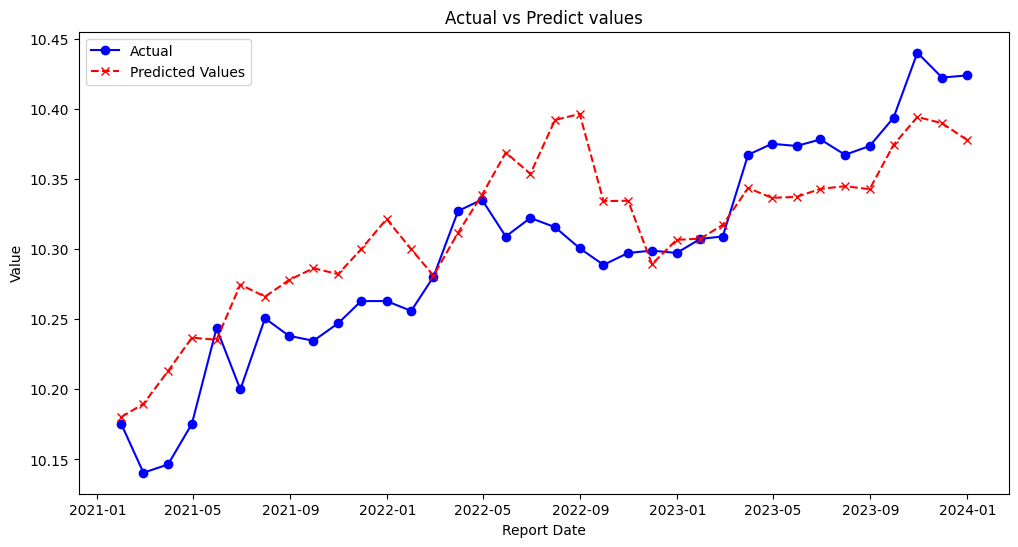

In [53]:
plt.figure(figsize=(12,6))
plt.plot(Gold_Factor_data['Report Date'],np.log(Gold_Factor_data['GoldBar_Sale']),label='Actual', color='blue',marker='o')
plt.plot(Prediction_df['Report Date'],np.log(Prediction_df['Predict']),label='Predicted Values',
         color='red',linestyle='--',marker='x')
plt.xlabel('Report Date')
plt.ylabel('Value')
plt.title('Actual vs Predict values')
plt.legend()
plt.show()

In [54]:
from sklearn.metrics import mean_absolute_error , mean_squared_error
# Mean Absolute Error (MAE)
MAE = mean_absolute_error(np.log(Gold_Factor_data['GoldBar_Sale']),np.log(Prediction_df['Predict']))
# Mean Squared Error (MSE)
MSE = mean_squared_error(np.log(Gold_Factor_data['GoldBar_Sale']),np.log(Prediction_df['Predict']))
# Root Mean Squared Error (RMSE)
RMSE = np.sqrt(MSE)
print('MAE : ',MAE) # ค่ายิ่งต้ำยิ่งดี
print('MSE : ',MSE) # ค่ายิ่งต้ำยิ่งดี
print('RMSE : ',RMSE) # ค่ายิ่งต้ำยิ้งดี

MAE :  0.035275349045732755
MSE :  0.0017766641935231962
RMSE :  0.04215049458218962


Version 2

In [55]:
# Gold_Factor_data[['LOGIT']+Factor_interested].corr()
Gold_Factor_data[['GoldBar_Sale']+Factor_interested].corr()

,GoldBar_Sale,(Inflation),LOG_PTT_แก๊สโซฮอล์_95_LAG_2,%CHANGE_PTT_ดีเซล_LAG_5
GoldBar_Sale,1.000000,0.274858,0.801228,-0.663569
(Inflation),0.274858,1.000000,0.648196,0.053666
LOG_PTT_แก๊สโซฮอล์_95_LAG_2,0.801228,0.648196,1.000000,-0.265939
%CHANGE_PTT_ดีเซล_LAG_5,-0.663569,0.053666,-0.265939,1.000000


In [57]:
from sklearn.linear_model import LinearRegression

In [58]:
X = Gold_Factor_data[['(Inflation)']]
y = np.log(Gold_Factor_data[['GoldBar_Sale']])

In [59]:
# y = ax + b
lrm = LinearRegression()
lrm.fit(X,y)

LinearRegression()

In [60]:
lrm.intercept_ # b

array([10.2710034])

In [61]:
lrm.coef_ # a

array([[0.02033631]])

In [62]:
predictions = lrm.predict(X)
predictions

array([[10.27527402],
       [10.27181685],
       [10.27283366],
       [10.27710429],
       [10.28096819],
       [10.28157828],
       [10.27385048],
       [10.27242694],
       [10.27486729],
       [10.27527402],
       [10.27690093],
       [10.27690093],
       [10.28157828],
       [10.30760876],
       [10.31167602],
       [10.31167602],
       [10.31737019],
       [10.32204754],
       [10.33180897],
       [10.33506278],
       [10.33445269],
       [10.3354695 ],
       [10.33648632],
       [10.33668968],
       [10.33282578],
       [10.31025248],
       [10.30659194],
       [10.30476167],
       [10.30252468],
       [10.29784733],
       [10.28849262],
       [10.28706908],
       [10.28381527],
       [10.28442536],
       [10.28279846],
       [10.28279846]])

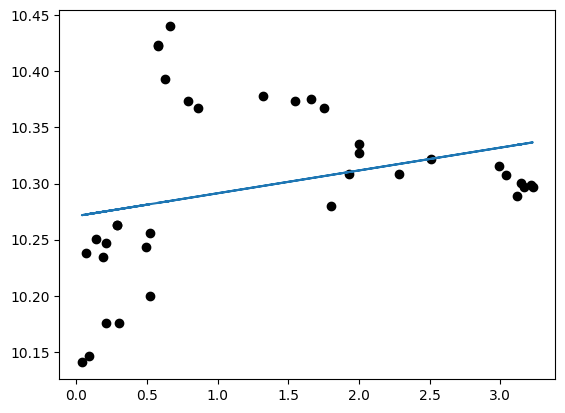

In [63]:
plt.scatter(X,y,color='black')
plt.plot(X,predictions)

In [64]:
from sklearn import metrics
metrics.mean_absolute_error(y,predictions)

0.057352211863596785

In [65]:
Gold_Factor_data[['GoldBar_Sale']+Factor_interested].corr()

,GoldBar_Sale,(Inflation),LOG_PTT_แก๊สโซฮอล์_95_LAG_2,%CHANGE_PTT_ดีเซล_LAG_5
GoldBar_Sale,1.000000,0.274858,0.801228,-0.663569
(Inflation),0.274858,1.000000,0.648196,0.053666
LOG_PTT_แก๊สโซฮอล์_95_LAG_2,0.801228,0.648196,1.000000,-0.265939
%CHANGE_PTT_ดีเซล_LAG_5,-0.663569,0.053666,-0.265939,1.000000


In [66]:
from sklearn.linear_model import LinearRegression
X = Gold_Factor_data[Factor_interested]
y = np.log(Gold_Factor_data[['GoldBar_Sale']])

In [67]:
lrm = LinearRegression()
lrm.fit(X,y)

LinearRegression()

In [68]:
predictions = lrm.predict(X)
np.exp(predictions)

array([[25302.73474493],
       [24368.88053568],
       [26725.2765196 ],
       [27072.25069696],
       [27529.52043383],
       [28723.55868835],
       [29058.11909415],
       [28021.99209109],
       [28701.61267248],
       [27488.78546289],
       [28588.17642778],
       [29484.68475795],
       [28189.90040338],
       [28674.63964761],
       [29998.28278568],
       [30513.22365767],
       [30579.88376925],
       [29686.21098898],
       [30521.8012454 ],
       [30981.12782962],
       [29114.61536689],
       [29833.12672799],
       [29413.3636998 ],
       [29929.4718201 ],
       [29954.26482259],
       [30536.13738761],
       [31497.91690199],
       [31428.054815  ],
       [31748.01846437],
       [31930.10349668],
       [31707.26636361],
       [31493.14424283],
       [33003.16180877],
       [33352.48553158],
       [33203.86818002],
       [32817.47123708]])

In [69]:
from sklearn import metrics
metrics.mean_absolute_error(y,predictions) # MAE

0.01920327723421063

In [70]:
y.mean()

GoldBar_Sale    10.29822
dtype: float64

In [71]:
metrics.mean_squared_error(y,predictions) # MSE

0.0005648029606671307

In [72]:
np.sqrt(metrics.mean_squared_error(y,predictions)) #RMSE

0.023765583533065848

In [73]:
lrm.score(X,y) # R-Square

0.9007478836959921

In [74]:
# MEAN : 10.040206
# MAE : 0.09521426489602582 ค่าต่ำ แสดงถึง โมเดลคาดการณ์ได้ดี
# MSE : 0.014789767007600822 ค่าต่ำแสดงถึง โมเดลคาดการณ์ได้ดี
# RMSE : 0.12161318599395718 # ค่าต่ำแสดงถึง ค่าความคลาดเคลื่อนจากค่าจริง
# R-Squared : 0.532340099507458 # โมเดลสามารถอธิบายความแปรผันของตัวแปรตามได้ประมาณ 53.23% 
# ซึ่งแสดงให้เห็นว่ามีความสัมพันธ์ระหว่างตัวแปรต้นและตัวแปรตาม แต่ยังไม่สูงมากนัก อาจมีปัจจัยอื่นที่ยังไม่ได้ถูกพิจารณา.
# metrics.mean_absolute_error(y,predictions)
# metrics.mean_squared_error(y,predictions)
# np.sqrt(metrics.mean_squared_error(y,predictions))

OLS Regression Model

In [75]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [76]:
X = Gold_Factor_data[Factor_interested]
y = (Gold_Factor_data[['GoldBar_Sale']])

In [77]:
model = sm.OLS(y,X)

In [78]:
# model.params # ceof
result = model.fit()
result.params 

(Inflation)                     -275.461534
LOG_PTT_แก๊สโซฮอล์_95_LAG_2     8747.573220
%CHANGE_PTT_ดีเซล_LAG_5       -11299.500698
dtype: float64

In [79]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           GoldBar_Sale   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.610e+04
Date:                Thu, 25 Jul 2024   Prob (F-statistic):                    2.74e-52
Time:                        09:00:20   Log-Likelihood:                         -290.82
No. Observations:                  36   AIC:                                      587.6
Df Residuals:                      33   BIC:                                      592.4
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
(Inflation)                  -275.4615    126.772     -2.173      0.037    -533.381     -17.542
LOG_PTT_แก๊สโซฮอล์_95_LAG_2  8747.5732     64.607    135.397      0.000    8616.130    8879.017
%CHANGE_PTT_ดีเซล_LAG_5      -1.13e+04   1423.889     -7.936      0.000   -1.42e+04   -8402.577
==============================================================================
Omnibus:                        3.340   Durbin-Watson:                   1.469
Prob(Omnibus):                  0.188   Jarque-Bera (JB):                2.370
Skew:                          -0.619   Prob(JB):                        0.306
Kurtosis:                       3.216   Cond. No.                         39.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Plot Graph

       ! Gold_data -> File


<Axes: >

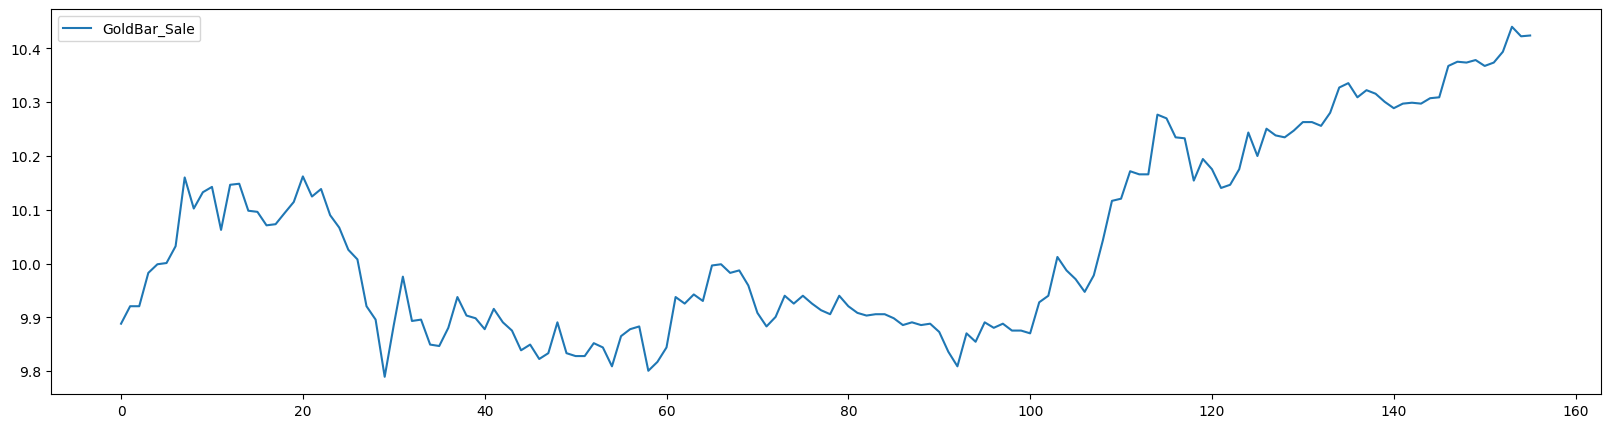

In [80]:
np.log(Gold_data['GoldBar_Sale']).plot(figsize = (20,5) , legend = True)

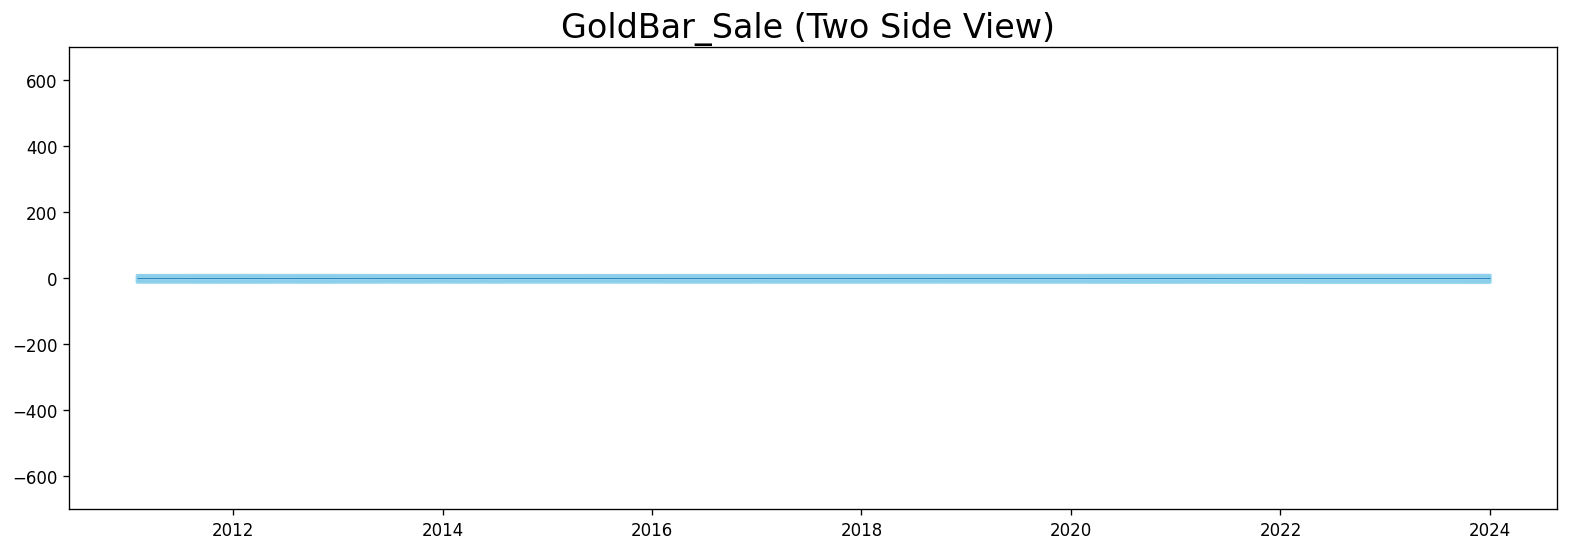

In [82]:
#Plot Two Side View
fig , ax = plt.subplots(1,1,figsize=(16,5) , dpi=120)
x = Gold_data['Report Date'].values

y1 = np.log(Gold_data['GoldBar_Sale'].values)

plt.fill_between( x , y1 = y1 , y2 = -y1 , alpha=0.9 , linewidth=2, color='skyblue')

plt.ylim(-700 , 700 )
plt.title('GoldBar_Sale (Two Side View) ' , fontsize = 20)

plt.hlines( y=0 , xmin = np.min(Gold_data['Report Date']) , xmax = np.max(Gold_data['Report Date']) , linewidth=0.5)

plt.show()

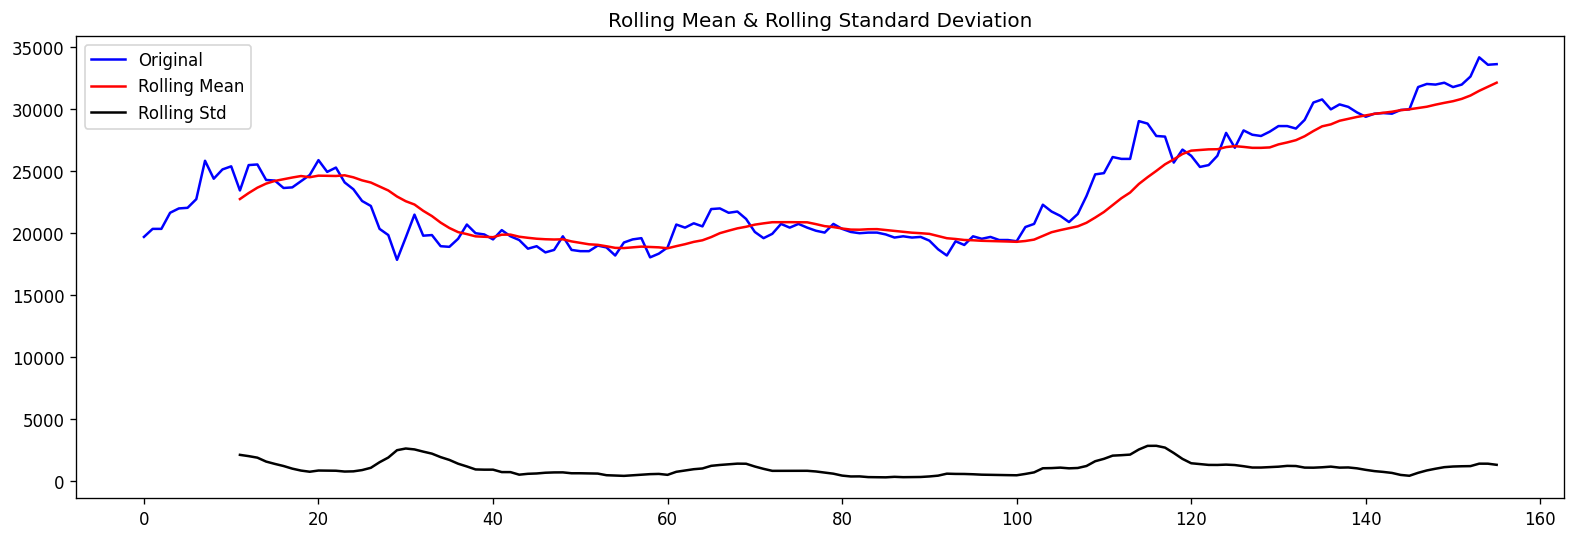

In [83]:
#ทดสอบ Stationary
rolling_mean = Gold_data['GoldBar_Sale'].rolling(window = 12).mean()
rolling_std = Gold_data['GoldBar_Sale'].rolling(window = 12).std()
fig , ax = plt.subplots(1,1,figsize=(16,5),dpi = 120)
plt.plot(Gold_data['GoldBar_Sale'],color = 'blue',label = 'Original')
plt.plot(rolling_mean , color = 'red' , label = 'Rolling Mean')
plt.plot(rolling_std , color = 'black' , label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [84]:
result = adfuller(Gold_data['GoldBar_Sale'])
print('ADF Statistic : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Critical Values:')
for key , value in result[4].items():
    print('\t{}: {}'.format(key,value))

ADF Statistic : -0.25132470546380203
p-value : 0.9321208869747761
Critical Values:
	1%: -3.4732590518613002
	5%: -2.880374082105334
	10%: -2.5768120811654525


In [85]:
# function
def get_stationarity(timeseries):
    rolling_mean = timeseries.rolling(window = 12).mean()
    rolling_std = timeseries.rolling(window = 12).std()
    original = plt.plot(timeseries, color = 'blue' , label ='Original')
    mean = plt.plot(rolling_mean , color = 'red' , label = 'Rolling Mean')
    std = plt.plot(rolling_std , color = 'black' , label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block =False)
    # Dickey-Fuller Test
    result = adfuller(timeseries)
    print('ADF Statiestic: {} '.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key , value in result[4].items():
        print('\t{} : {}'.format(key,value))

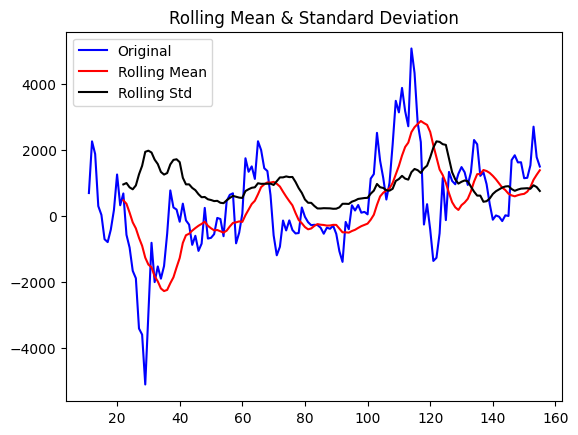

ADF Statiestic: -3.3308983120231344 
p-value: 0.013552562125553171
Critical Values:
	1% : -3.476597917537401
	5% : -2.8818291230495543
	10% : -2.5775887982253085


In [86]:
# วิธีแรกในการปรับข้อมูลให้เรียบคือ การลบด้วยค่าเฉลี่ยเคลื่อนที่ 12 เดือนย้อนหลังออกไป เพื่อกำจัด ฤดูกาลกับแนวโน้ม
rolling_mean = Gold_data['GoldBar_Sale'].rolling(window=12).mean()
df_log_minus_mean = Gold_data['GoldBar_Sale'] - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

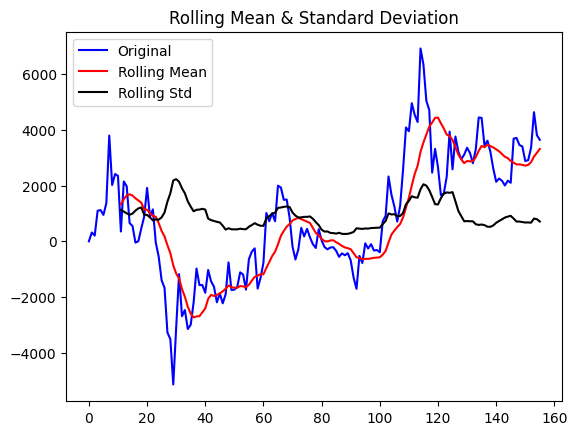

ADF Statiestic: -2.206766739159659 
p-value: 0.20379869426954533
Critical Values:
	1% : -3.4732590518613002
	5% : -2.880374082105334
	10% : -2.5768120811654525


In [87]:
# p value ต่ำแล้ว ลองวิธี take log
rolling_mean_exp_decay = Gold_data['GoldBar_Sale'].ewm(halflife=12,min_periods=0,adjust=True).mean()

df_log_exp_decay = Gold_data['GoldBar_Sale'] - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace = True)
get_stationarity(df_log_exp_decay)

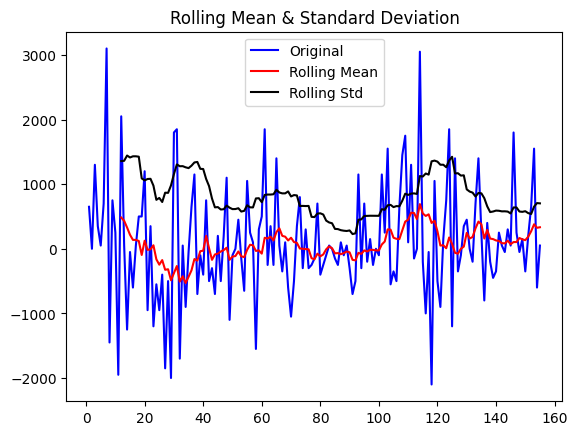

ADF Statiestic: -13.656836430155131 
p-value: 1.5480057912548305e-25
Critical Values:
	1% : -3.473542528196209
	5% : -2.880497674144038
	10% : -2.576878053634677


In [88]:
# วิธีลบด้วยค่าก่อนหน้า
df_log_shift = Gold_data['GoldBar_Sale'] - Gold_data['GoldBar_Sale'].shift()
df_log_shift.dropna(inplace = True)
get_stationarity(df_log_shift)

สร้าง ARIMA Model

In [89]:
# import libaries
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import joblib
import os

In [90]:
# 1,1,2 ARIMA Model
model = pm.ARIMA(order=(1,1,2),seasonal=False)
model_fit = model.fit(Gold_data['GoldBar_Sale'],disp=0)
print(model_fit.summary())

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  156
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -1269.331
Date:                Thu, 25 Jul 2024   AIC                           2548.662
Time:                        09:01:20   BIC                           2563.879
Sample:                             0   HQIC                          2554.843
                                - 156                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     72.3140    263.937      0.274      0.784    -444.993     589.621
ar.L1          0.2731      2.607      0.105      0.917      -4.837       5.383
ma.L1         -0.3123      2.600     -0.120      0.9

In [91]:
# 1,1,1 ARIMA Model
model = pm.ARIMA(order=(1,1,1),seasonal=False)
model_fit = model.fit(Gold_data['GoldBar_Sale'],disp=0)
print(model_fit.summary())

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  156
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1269.381
Date:                Thu, 25 Jul 2024   AIC                           2546.762
Time:                        09:01:21   BIC                           2558.936
Sample:                             0   HQIC                          2551.707
                                - 156                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     87.9640    196.459      0.448      0.654    -297.089     473.017
ar.L1          0.0038      1.992      0.002      0.998      -3.901       3.909
ma.L1         -0.0408      1.986     -0.021      0.9

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


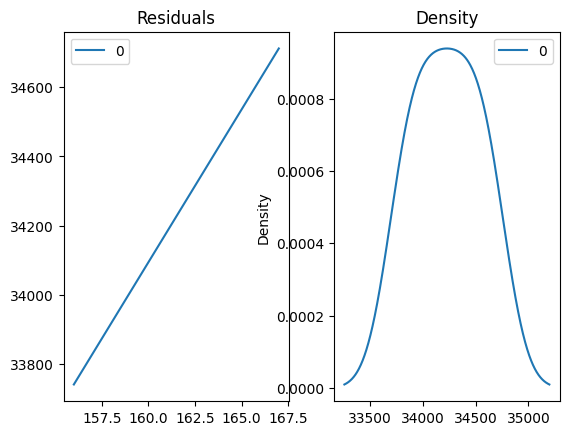

In [92]:
# เลือกอันที่ P > |Z| ดีๆ คือค่าน้อยๆ
preds, conf_int = model_fit.predict(n_periods=12, return_conf_int=True)
residuals = pd.DataFrame(preds)
fig,ax = plt.subplots(1,2)
residuals.plot(title="Residuals",ax=ax[0])
residuals.plot(kind='kde',title='Density',ax=ax[1])
plt.show()

ARIMA MODEL pmdarima 

In [111]:
arima = pm.auto_arima(Gold_data['GoldBar_Sale'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                     trace=False, suppress_warnings=True, stepwise = True,
                     error_action='ignore', m=12)

preds, conf_int = arima.predict(n_periods=12, return_conf_int=True)
arima_only_predict = preds
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  156
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1267.587
Date:                              Thu, 25 Jul 2024   AIC                           2541.174
Time:                                      09:11:37   BIC                           2550.304
Sample:                                           0   HQIC                          2544.882
                                              - 156                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8231      0.219      3.752      0.000       0.393       1.253
ma.S.L12      -0.7369      0.252     -2.928      0.003      -1.230      -0.244
sigma2      7.427e+05   6.71e+04     11.062      0.000    6.11e+05    8.74e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):                15.53
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.45
Prob(H) (two-sided):                  0.44   Kurtosis:                         4.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [112]:
arima_only_predict

156    33732.939932
157    33826.960198
158    34053.291215
159    34175.054362
160    34188.187541
161    34206.301530
162    34336.729756
163    34358.253980
164    34315.845074
165    34484.022643
166    34336.904626
167    34393.809184
dtype: float64

In [95]:
def eomonth(d, months=0):
    months = int(months)
    if isinstance(d, list):
        return [eomonth(d0, months) for d0 in d]
    elif isinstance(d, pd.Series):
        return d.map(lambda d0: eomonth(d0, months))
    else:
        y, m = divmod(d.month + months + 1, 12)
        # y, m = int(y), int(m)
        if m==0:
            y -= 1
            m = 12
        return pytz.UTC.localize(datetime.datetime(d.year + y, m, 1) - datetime.timedelta(days=1))

In [96]:
Date = Gold_data['Report Date']
last_date = Date.iloc[-1]
arr = []
period = 12
for i in range(period):
    next_month = eomonth(last_date,i+1)
    arr = np.append(arr,next_month)

Date_forecast_period = pd.DataFrame(arr)
Date_forecast_period.columns = ['Report Date']
Date_forecast_period['Report Date'] = Date_forecast_period['Report Date'].dt.tz_localize(None)

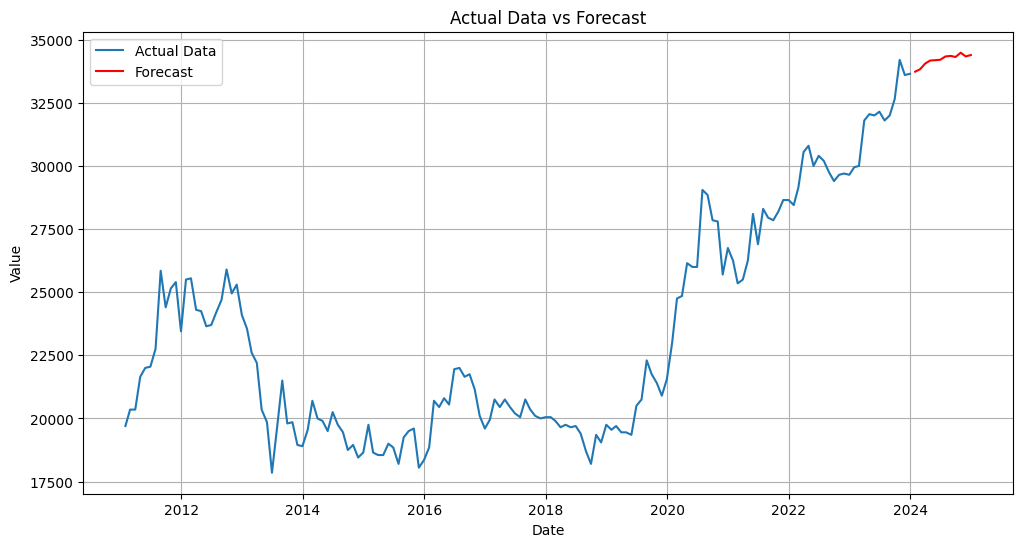

In [97]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,preds , label='Forecast' , color = 'red')
# plt.fill_between(Date_forecast_period , conf_int[:,0],conf_int[:,1] , color='pink' , alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

Forecast GoldBar_Sale price in Thailand with Feature_Seletion by LinearRegression and ARIMA model

In [98]:
def eomonth(d, months=0):
    months = int(months)
    if isinstance(d, list):
        return [eomonth(d0, months) for d0 in d]
    elif isinstance(d, pd.Series):
        return d.map(lambda d0: eomonth(d0, months))
    else:
        y, m = divmod(d.month + months + 1, 12)
        # y, m = int(y), int(m)
        if m==0:
            y -= 1
            m = 12
        return pytz.UTC.localize(datetime.datetime(d.year + y, m, 1) - datetime.timedelta(days=1))

In [99]:
Date = Gold_data['Report Date']
last_date = Date.iloc[-1]
arr = []
period = 12
for i in range(period):
    next_month = eomonth(last_date,i+1)
    arr = np.append(arr,next_month)

Date_forecast_period = pd.DataFrame(arr)
Date_forecast_period.columns = ['Report Date']
Date_forecast_period['Report Date'] = Date_forecast_period['Report Date'].dt.tz_localize(None)

In [100]:
Factor_data_selected_P = Gold_Factor_data[[
                                '(Inflation)',
]]
Factor_data_selected_NoP = Gold_Factor_data[[
    'LOG_PTT_แก๊สโซฮอล์_95_LAG_2',
    '%CHANGE_PTT_ดีเซล_LAG_5'
]]

In [101]:
# Forecast ข้อมูล
output2_base = pd.DataFrame()
output2_worst = pd.DataFrame()
output2_best = pd.DataFrame()
for col in Factor_data_selected_NoP:
    data = Factor_data_selected_NoP[col]
    df = pd.DataFrame(data)
    df['LOG'] = np.log(df.values/df.shift(1))
    
    df = df.replace((np.inf, -np.inf, np.nan),0).reset_index(drop=True)
    df2 = df[1:]
    arima = pm.auto_arima(df2['LOG'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                     trace=False, suppress_warnings=True, stepwise = True, seasonal=True,
                     error_action='ignore', m=12)
    preds, conf_int = arima.predict(n_periods=period, return_conf_int=True)

    output = pd.DataFrame(preds)
    output.columns =['LOG']
    per_10 = np.percentile(df2['LOG'], 10)
    per_50 = np.percentile(df2['LOG'], 50)
    per_90 = np.percentile(df2['LOG'], 90)
    worst_return = per_50 - per_10
    best_return = per_90 - per_50

    v = Factor_data_selected_NoP[col].iloc[-1]
    # print(v)
    base = []
    worst = []
    best = []
    for i in output.iterrows():
        x_base = v*math.exp(i[1].values)
        x_worst = v*math.exp(i[1].values - worst_return)
        x_best = v*math.exp(i[1].values + best_return)
        v = x_base
        base = np.append(base, x_base)
        worst = np.append(worst, x_worst)
        best = np.append(best, x_best)
    output_base = pd.DataFrame(base)
    output_worst = pd.DataFrame(worst)
    output_best = pd.DataFrame(best)
    output2_base[col] = output_base
    output2_worst[col] = output_worst
    output2_best[col] = output_best
    # print(x_base)

C:\Users\temp5\AppData\Local\Temp\ipykernel_10472\1674799205.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_base = v*math.exp(i[1].values)
C:\Users\temp5\AppData\Local\Temp\ipykernel_10472\1674799205.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_worst = v*math.exp(i[1].values - worst_return)
C:\Users\temp5\AppData\Local\Temp\ipykernel_10472\1674799205.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_best = v*math.exp(i[1].values + best_return

In [102]:
output3_worst = Date_forecast_period.join(output2_worst)
output3_base = Date_forecast_period.join(output2_base)
output3_best = Date_forecast_period.join(output2_best)

# output3_worst.to_excel(result_worst_NoP)
# output3_base.to_excel(result_base_NoP)
# output3_best.to_excel(result_best_NoP)

In [103]:
# for rate type data

output2_base = pd.DataFrame()
output2_worst = pd.DataFrame()
output2_best = pd.DataFrame()
for col in Factor_data_selected_P:
    data = Factor_data_selected_P[col]
    df2 = data[1:]
    arima = pm.auto_arima(df2, start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                     trace=False, suppress_warnings=True, stepwise = True,
                     error_action='ignore', m=12)
    preds, conf_int = arima.predict(n_periods=period, return_conf_int=True)

    output = pd.DataFrame(preds)
    output.columns =['LOG']
    var = math.sqrt(np.cov(df2))
    worst_return = 1.28*var/math.sqrt(len(df2))
    best_return = 1.28*var/math.sqrt(len(df2))

    v = Factor_data_selected_P[col].iloc[-1]
    base = []
    worst = []
    best = []
    for i in output.iterrows():
        x_base = i[1]
        x_worst = i[1].values - worst_return
        x_best = i[1].values + best_return
        v = x_base
        base = np.append(base, x_base)
        worst = np.append(worst, x_worst)
        best = np.append(best, x_best)
    output_base = pd.DataFrame(base)
    output_worst = pd.DataFrame(worst)
    output_best = pd.DataFrame(best)
    output2_base[col] = output_base
    if col == 'Unemployment Rate':
        output2_worst[col] = output_best
        output2_best[col] = output_worst
    else:
        output2_worst[col] = output_worst
        output2_best[col] = output_best

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [104]:
output3_base = output3_base.join(output2_base)

In [105]:
output3_base

,Report Date,LOG_PTT_แก๊สโซฮอล์_95_LAG_2,%CHANGE_PTT_ดีเซล_LAG_5,(Inflation)
0,2024-01-31,3.660790,-0.062617,0.717504
1,2024-02-29,3.677513,-0.062617,1.711454
2,2024-03-31,3.694313,-0.062617,1.822917
3,2024-04-30,3.711189,-0.062617,1.842520
4,2024-05-31,3.728142,-0.062617,1.874462
5,2024-06-30,3.745172,-0.062617,2.013551
6,2024-07-31,3.762281,-0.062617,2.364008
7,2024-08-31,3.779467,-0.062617,2.343604
8,2024-09-30,3.796732,-0.062617,2.404491
9,2024-10-31,3.814076,-0.062617,2.284145


In [114]:
New_Predict_linear = (Test_Stat['const'].values + (Test_Stat['x1'].values * output3_base[Test_Stat['FACTOR_1']].values) +(Test_Stat['x2'].values * (output3_base[Test_Stat['FACTOR_2']].values)) +(Test_Stat['x3'].values * (output3_base[Test_Stat['FACTOR_3']].values)))
# New_Predict.to_excel('Test.xlsx')
np.exp(New_Predict_linear)

array([[32954.03882646],
       [32650.87822597],
       [32802.03253673],
       [33002.32637317],
       [33198.39251252],
       [33340.56466086],
       [33373.58520703],
       [33602.38388985],
       [33790.67707499],
       [34077.70372721],
       [34313.4953461 ],
       [34593.29879708]])

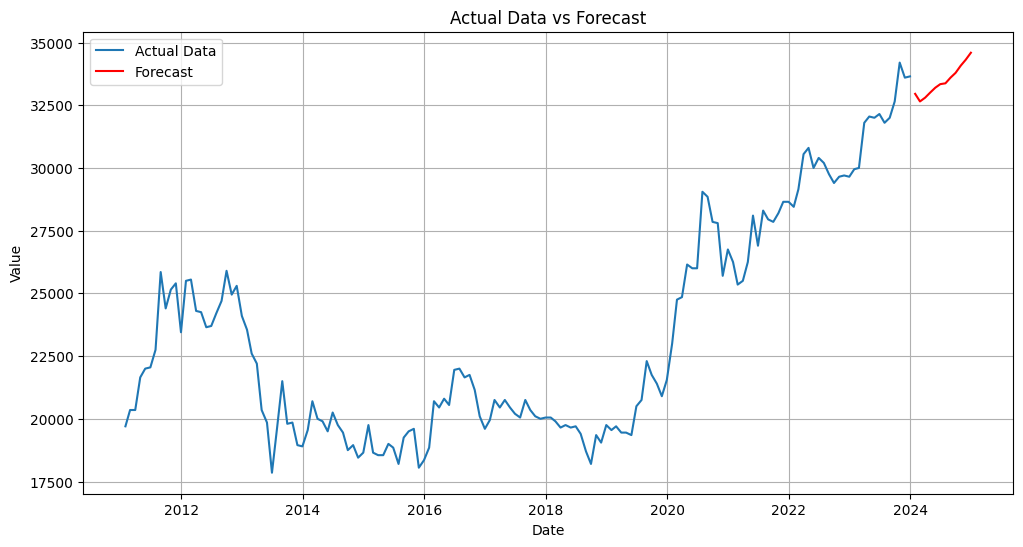

In [107]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(New_Predict), label='Forecast' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

#ARIMA only from pmdarima VS ARIMA and Multiple Linear Regression 3 Factor

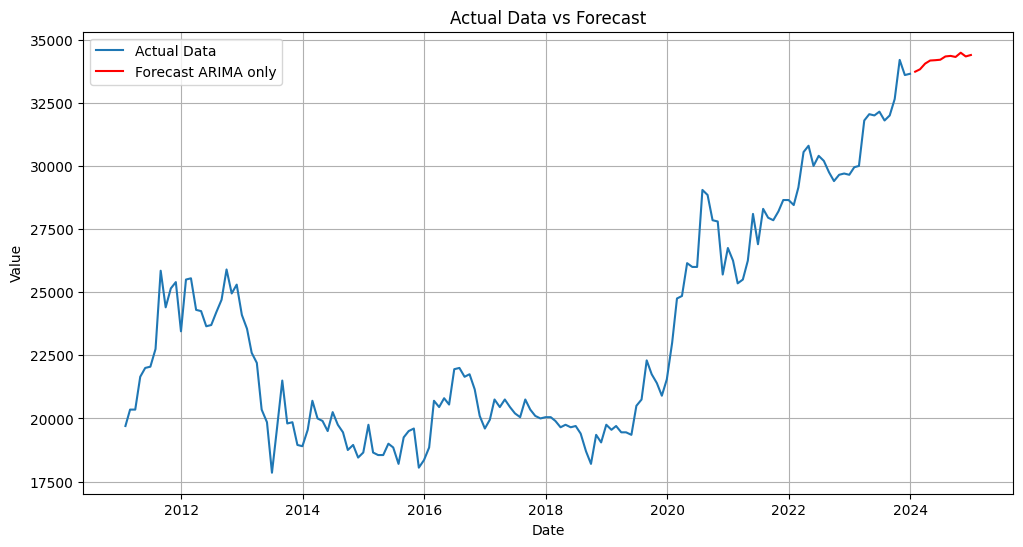

In [113]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,arima_only_predict, label='Forecast ARIMA only' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

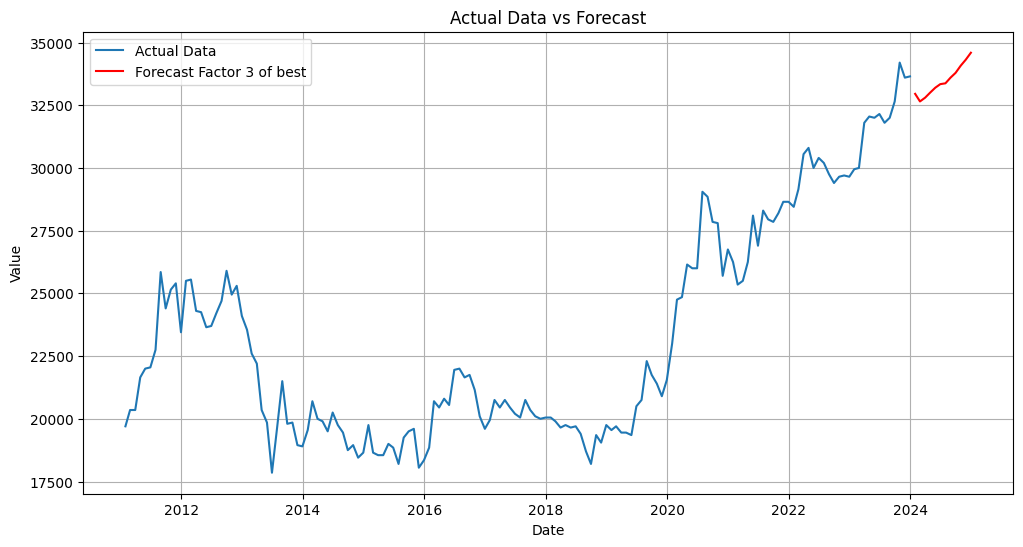

In [115]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(New_Predict_linear), label='Forecast Factor 3 of best Linear regression' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

 Polynomial Regression model

In [372]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2,include_bias=False)
# X = np.log(Gold_Factor_data['GoldBar_Sale'])
X = Gold_Factor_data[Factor_interested]
y = pd.DataFrame(np.log(Gold_Factor_data['GoldBar_Sale'].values),columns=['Y'])

X_poly = poly_features.fit_transform(X)
model_poly = LinearRegression()
model_poly.fit(X_poly,y)
X_test_poly = poly_features.transform(X)
y_pred_poly = model_poly.predict(X_test_poly)
y_pred_poly_test = y_pred_poly

X_test_poly = poly_features.transform(output3_base[Factor_interested])
y_pred_poly = model_poly.predict(X_test_poly)
Predict_Poly = y_pred_poly

In [376]:
print(f"{Factor_interested[0]} x1 :" ,model_poly.coef_[0][0])
print(f"{Factor_interested[0]} x2" ,model_poly.coef_[0][1])
print(f"{Factor_interested[0]} x3" ,model_poly.coef_[0][2])
print(f"{Factor_interested[1]} x1 :" ,model_poly.coef_[0][3])
print(f"{Factor_interested[1]} x2" ,model_poly.coef_[0][4])
print(f"{Factor_interested[1]} x3" ,model_poly.coef_[0][5])
print(f"{Factor_interested[2]} x1 :" ,model_poly.coef_[0][6])
print(f"{Factor_interested[2]} x2" ,model_poly.coef_[0][7])
print(f"{Factor_interested[2]} x3" ,model_poly.coef_[0][8])
print("Intercept : ", model_poly.intercept_)
print("R-Squared : " ,model_poly.score(X_poly,y))
print("MAE : ",metrics.mean_absolute_error(y,y_pred_poly_test))
print("MAPE : ",metrics.mean_absolute_percentage_error(y,y_pred_poly_test))
print("MSE : ",metrics.mean_squared_error(y,y_pred_poly_test))
print("RMSE : " ,np.sqrt(metrics.mean_squared_error(y,y_pred_poly_test)))

(Inflation) x1 : 0.661261082978224
(Inflation) x2 -2.43309337067516
(Inflation) x3 0.015218651990893983
LOG_PTT_แก๊สโซฮอล์_95_LAG_2 x1 : -0.00407845976218435
LOG_PTT_แก๊สโซฮอล์_95_LAG_2 x2 -0.1854723278619712
LOG_PTT_แก๊สโซฮอล์_95_LAG_2 x3 0.004180013417466419
%CHANGE_PTT_ดีเซล_LAG_5 x1 : 0.4275963531552335
%CHANGE_PTT_ดีเซล_LAG_5 x2 -0.09255622009114063
%CHANGE_PTT_ดีเซล_LAG_5 x3 0.9483621289399697
Intercept :  [13.58399337]
R-Squared :  0.9539938253274842
MAE :  0.012645543526792776
MAPE :  0.0012309179319932172
MSE :  0.00026180221270462523
RMSE :  0.016180303232777353


In [184]:
Predict_Poly.mean() # MEAN

10.41151431975733

In [183]:
from sklearn import metrics
metrics.mean_absolute_error(y,y_pred_poly_test) # MAE

0.012645543526792776

In [185]:
metrics.mean_squared_error(y,y_pred_poly_test) # MSE

0.00026180221270462523

In [187]:
np.sqrt(metrics.mean_squared_error(y,y_pred_poly_test)) #RMSE

0.016180303232777353

In [174]:
np.exp(Predict_Poly)

array([[33400.19677738],
       [32701.53323097],
       [32784.74478272],
       [32980.11179694],
       [33162.90397966],
       [33172.20722623],
       [32771.62262142],
       [33014.3306054 ],
       [33103.93028615],
       [33587.28778308],
       [33876.15067987],
       [34366.99993322]])

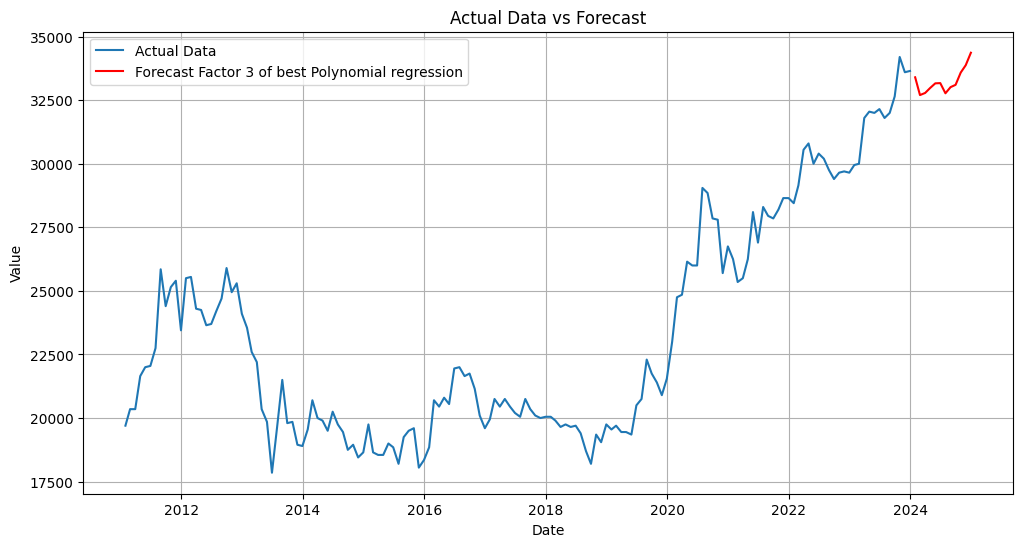

In [189]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(Predict_Poly), label='Forecast Factor 3 of best Polynomial regression' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

Linear Regression # only

In [364]:
# linear and arima
X = Gold_Factor_data[Factor_interested]
y = pd.DataFrame(np.log(Gold_Factor_data['GoldBar_Sale'].values),columns=['Y'])

model_linear = LinearRegression()
model_linear.fit(X,y)
y_pred_linear_test = model_linear.predict(X)
y_pred_linear = model_linear.predict(output3_base[Factor_interested])
print(np.exp(y_pred_linear))

[[32954.03882646]
 [32650.87822597]
 [32802.03253673]
 [33002.32637317]
 [33198.39251252]
 [33340.56466086]
 [33373.58520703]
 [33602.38388985]
 [33790.67707498]
 [34077.70372721]
 [34313.4953461 ]
 [34593.29879708]]


In [362]:
model_linear

LinearRegression()

In [377]:
print(f"{Factor_interested[0]} x1 :",model_linear.coef_[0][0])
print(f"{Factor_interested[1]} x2 :",model_linear.coef_[0][1])
print(f"{Factor_interested[2]} x3 :",model_linear.coef_[0][2])
print("intercept :",model_linear.intercept_)
print("R-squared :",model_linear.score(X,y))
n , p = X.shape
adj_r2_linear = 1 - ( ((1 - model_linear.score(X,y))*(n - 1)) / (n - p - 1) )
print("Adj-R-squared : ",adj_r2_linear)
print("MAE : ",metrics.mean_absolute_error(y,y_pred_linear_test))
print("MAPE : ",metrics.mean_absolute_percentage_error(y,y_pred_linear_test))
print("MSE : ",metrics.mean_squared_error(y,y_pred_linear_test))
print("RMSE : " ,np.sqrt(metrics.mean_squared_error(y,y_pred_linear_test)))


(Inflation) x1 : -0.015673705040831345
LOG_PTT_แก๊สโซฮอล์_95_LAG_2 x2 : 0.37893048854814965
%CHANGE_PTT_ดีเซล_LAG_5 x3 : -0.3306620814874827
intercept : [9.00622476]
R-squared : 0.9007478836959921
Adj-R-squared :  0.8914429977924914
MAE :  0.01920327723421063
MAPE :  0.0018700237372205515
MSE :  0.0005648029606671307
RMSE :  0.023765583533065848


In [352]:
np.exp(y_pred_linear)

array([[32954.03882646],
       [32650.87822597],
       [32802.03253673],
       [33002.32637317],
       [33198.39251252],
       [33340.56466086],
       [33373.58520703],
       [33602.38388985],
       [33790.67707498],
       [34077.70372721],
       [34313.4953461 ],
       [34593.29879708]])

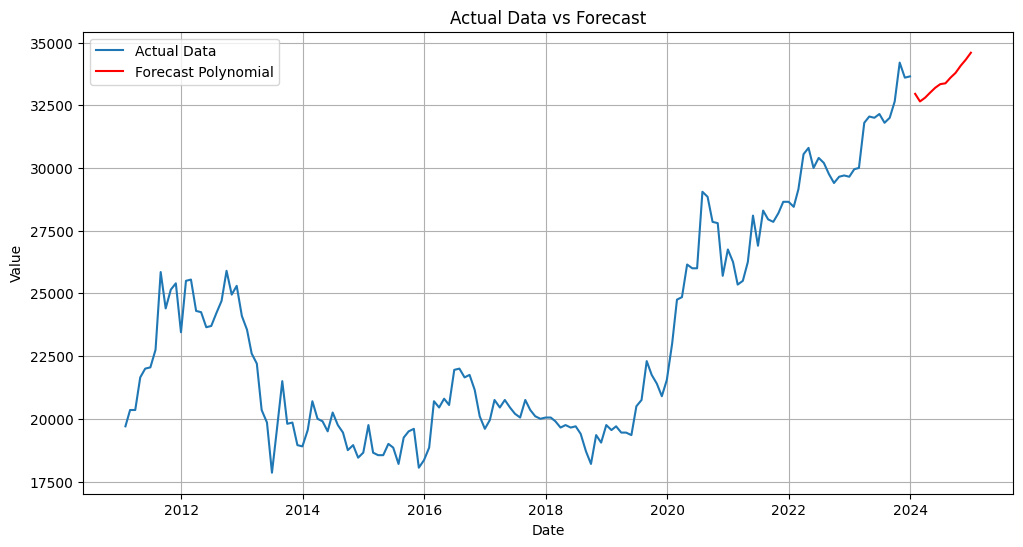

In [166]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_linear), label='Forecast Polynomial' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

Elastic Net Model

In [378]:
#Elastic Net คือ การรวมระหว่าง Ridge Regression และ Lasso Regression เข้าด้วยกัน
from sklearn.linear_model import ElasticNet
X = Gold_Factor_data[Factor_interested]
y = pd.DataFrame(np.log(Gold_Factor_data['GoldBar_Sale'].values),columns=['Y'])

elastic_net_model = ElasticNet(alpha=0.001, l1_ratio=0.5)  # l1_ratio เป็นการควบคุมการผสมระหว่าง L1 และ L2
elastic_net_model.fit(X, y)
y_pred_test_enet = elastic_net_model.predict(X)
print("x1 x2 x3 [Coeff] :",elastic_net_model.coef_)
print("Intercept : ",elastic_net_model.intercept_)
print("R-squared : ",elastic_net_model.score(X,y))
adj_r2_elastic_net = 1 - ( ((1 - elastic_net_model.score(X,y))*(n - 1)) / (n - p - 1) )
print("Adj-R-squared : ",adj_r2_elastic_net)
elastic_net_model = ElasticNet(alpha=0.001, l1_ratio=0.5)  # l1_ratio เป็นการควบคุมการผสมระหว่าง L1 และ L2
elastic_net_model.fit(X, y)
y_pred_elastic_net = elastic_net_model.predict(output3_base[Factor_interested])
print("MAE : ",metrics.mean_absolute_error(y,y_pred_test_enet))
print("MAPE : ",metrics.mean_absolute_percentage_error(y,y_pred_test_enet))
print("MSE : ",metrics.mean_squared_error(y,y_pred_test_enet))
print("RMSE : " ,np.sqrt(metrics.mean_squared_error(y,y_pred_test_enet)))

x1 x2 x3 [Coeff] : [-0.0128474   0.35192495 -0.27458215]
Intercept :  [9.0945338]
R-squared :  0.8910075361851564
Adj-R-squared :  0.8807894927025148
MAE :  0.02029250543925877
MAPE :  0.001972805109985761
MSE :  0.0006202312710841711
RMSE :  0.02490444279810675


In [300]:
np.exp(y_pred_elastic_net)

array([32559.77215111, 32336.38494434, 32481.57956013, 32666.83620569,
       32848.83338266, 32987.30452694, 33037.43016778, 33246.57177098,
       33423.03771162, 33679.70003027, 33894.99243174, 34146.06618491])

Ridge Regression model

In [379]:
#Ridge Regression
from sklearn.linear_model import Ridge
X = Gold_Factor_data[Factor_interested]
y = pd.DataFrame(np.log(Gold_Factor_data['GoldBar_Sale'].values),columns=['Y'])

ridge_model = Ridge(alpha=0.05)  # alpha คือค่า penalty
ridge_model.fit(X, y)
print("Coef of x1 , x2 , x3 : ",ridge_model.coef_)
print("Intercept : ",ridge_model.intercept_)
print("R-squared : ",ridge_model.score(X,y))
adj_r2_ridge = 1 - ( ((1 - ridge_model.score(X,y))*(n - 1)) / (n - p - 1) )
print("Adj-R-squared : ",adj_r2_ridge)
y_pred_ridge_test = ridge_model.predict(X)
y_pred_ridge = ridge_model.predict(output3_base[Factor_interested])
print("MAE : ",metrics.mean_absolute_error(y,y_pred_ridge_test))
print("MAPE : ",metrics.mean_absolute_percentage_error(y,y_pred_ridge_test))
print("MSE : ",metrics.mean_squared_error(y,y_pred_ridge_test))
print("RMSE : " ,np.sqrt(metrics.mean_squared_error(y,y_pred_ridge_test)))

Coef of x1 , x2 , x3 :  [[-0.01387032  0.35925649 -0.29560788]]
Intercept :  [9.07116576]
R-squared :  0.8964876026394152
Adj-R-squared :  0.8867833153868604
MAE :  0.019765983713270183
MAPE :  0.0019227844208788017
MSE :  0.000589046467441924
RMSE :  0.024270279508936933


In [331]:
print(np.exp(y_pred_ridge))

[[32692.03167493]
 [32438.7198329 ]
 [32584.67201939]
 [32773.91428125]
 [32959.52758816]
 [33097.88890908]
 [33140.45803236]
 [33355.15051625]
 [33534.34887564]
 [33800.32381183]
 [34021.38388601]
 [34281.12324828]]


Lasso Regression model

In [382]:
from sklearn.linear_model import Lasso
X = Gold_Factor_data[Factor_interested]
y = pd.DataFrame(np.log(Gold_Factor_data['GoldBar_Sale'].values),columns=['Y'])

lasso_model = Lasso(alpha=0.001)  # alpha คือค่า penalty
lasso_model.fit(X, y)
y_pred_test_lasso = lasso_model.predict(X)
print("Coef of x1 , x2 , x3 : ",lasso_model.coef_)
print("Intercept : ",lasso_model.intercept_)
print("R-squared : ",lasso_model.score(X,y))
adj_r2_lasso = 1 - ( ((1 - lasso_model.score(X,y))*(n - 1)) / (n - p - 1) )
print("Adj-R-squared : ",adj_r2_lasso)
y_pred_lasso = lasso_model.predict(output3_base[Factor_interested])
print("MAE : ",metrics.mean_absolute_error(y,y_pred_test_lasso))
print("MAPE : ",metrics.mean_absolute_percentage_error(y,y_pred_test_lasso))
print("MSE : ",metrics.mean_squared_error(y,y_pred_test_lasso))
print("RMSE : " ,np.sqrt(metrics.mean_squared_error(y,y_pred_test_lasso)))

Coef of x1 , x2 , x3 :  [-0.01135955  0.33937241 -0.2412449 ]
Intercept :  [9.13501679]
R-squared :  0.8773245267660278
Adj-R-squared :  0.8658237011503429
MAE :  0.021534482911831007
MAPE :  0.002091502666683164
MSE :  0.0006980956483745123
RMSE :  0.026421499737420515


In [347]:
np.exp(y_pred_lasso)

array([32349.16996912, 32168.02079046, 32311.00428556, 32489.35270663,
       32664.96175757, 32802.43364269, 32862.35483089, 33062.25078353,
       33233.5463658 , 33475.46900172, 33681.15103258, 33918.39252473])

In [305]:
# #SVR Support Vector Regression
# from sklearn.svm import SVR
# X = Gold_Factor_data[Factor_interested]
# y = pd.DataFrame(np.log(Gold_Factor_data['GoldBar_Sale'].values),columns=['Y'])

# svr_model = SVR(kernel='linear')  # สามารถเลือก kernel ที่แตกต่างกันได้
# svr_model.fit(X, y)
# print("x1 x2 x3 [Coef] :",svr_model.coef_)
# print("Intercept : ",svr_model.intercept_)
# print("R-squared : ",svr_model.score(X,y))
# y_pred_svr_test = svr_model.predict(X)
# y_pred_svr = svr_model.predict(output3_base[Factor_interested])

In [304]:
# print(np.exp(y_pred_svr))

#Show All output

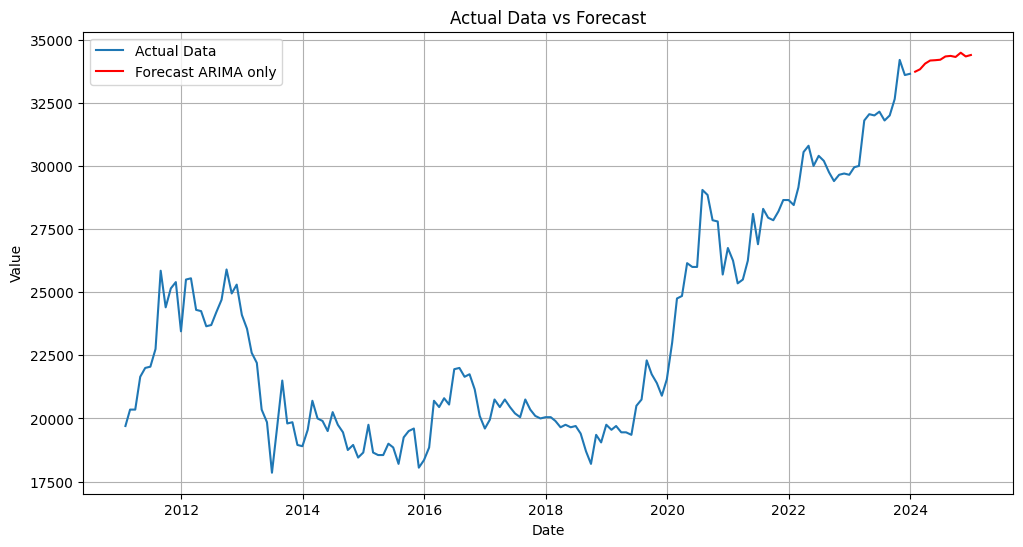

In [190]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,arima_only_predict, label='Forecast ARIMA only' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [193]:
arima_only_predict

156    33732.939932
157    33826.960198
158    34053.291215
159    34175.054362
160    34188.187541
161    34206.301530
162    34336.729756
163    34358.253980
164    34315.845074
165    34484.022643
166    34336.904626
167    34393.809184
dtype: float64

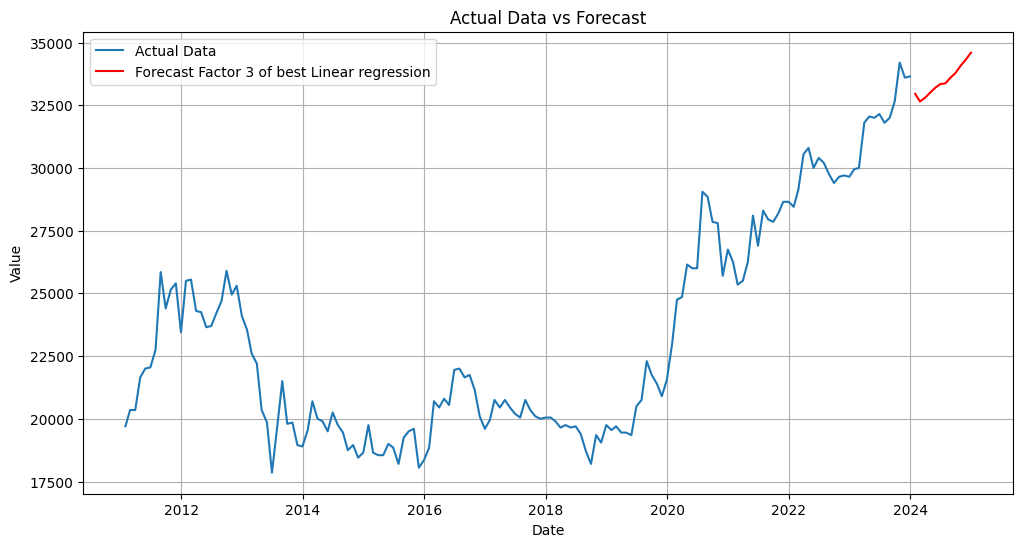

In [385]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_linear), label='Forecast Factor 3 of best Linear regression' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [194]:
np.exp(New_Predict_linear)

array([[32954.03882646],
       [32650.87822597],
       [32802.03253673],
       [33002.32637317],
       [33198.39251252],
       [33340.56466086],
       [33373.58520703],
       [33602.38388985],
       [33790.67707499],
       [34077.70372721],
       [34313.4953461 ],
       [34593.29879708]])

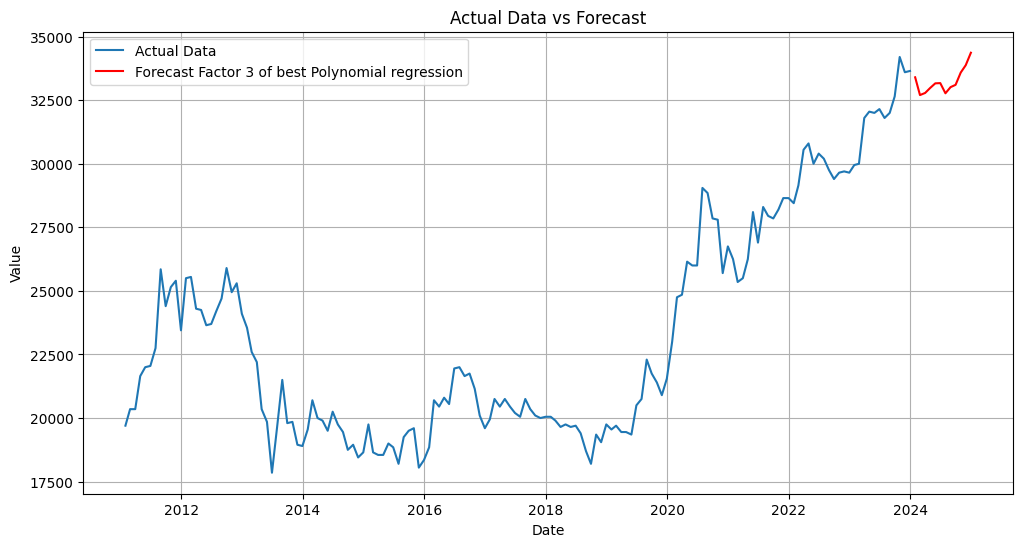

In [192]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(Predict_Poly), label='Forecast Factor 3 of best Polynomial regression' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [195]:
np.exp(Predict_Poly)

array([[33400.19677738],
       [32701.53323097],
       [32784.74478272],
       [32980.11179694],
       [33162.90397966],
       [33172.20722623],
       [32771.62262142],
       [33014.3306054 ],
       [33103.93028615],
       [33587.28778308],
       [33876.15067987],
       [34366.99993322]])

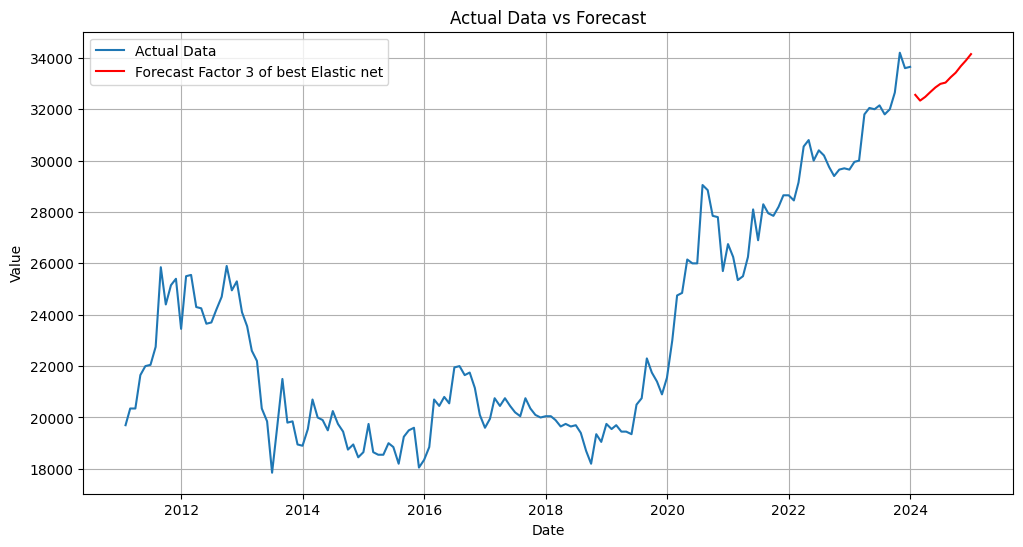

In [383]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_elastic_net), label='Forecast Factor 3 of best Elastic net' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [390]:
np.exp(y_pred_elastic_net)

array([32559.77215111, 32336.38494434, 32481.57956013, 32666.83620569,
       32848.83338266, 32987.30452694, 33037.43016778, 33246.57177098,
       33423.03771162, 33679.70003027, 33894.99243174, 34146.06618491])

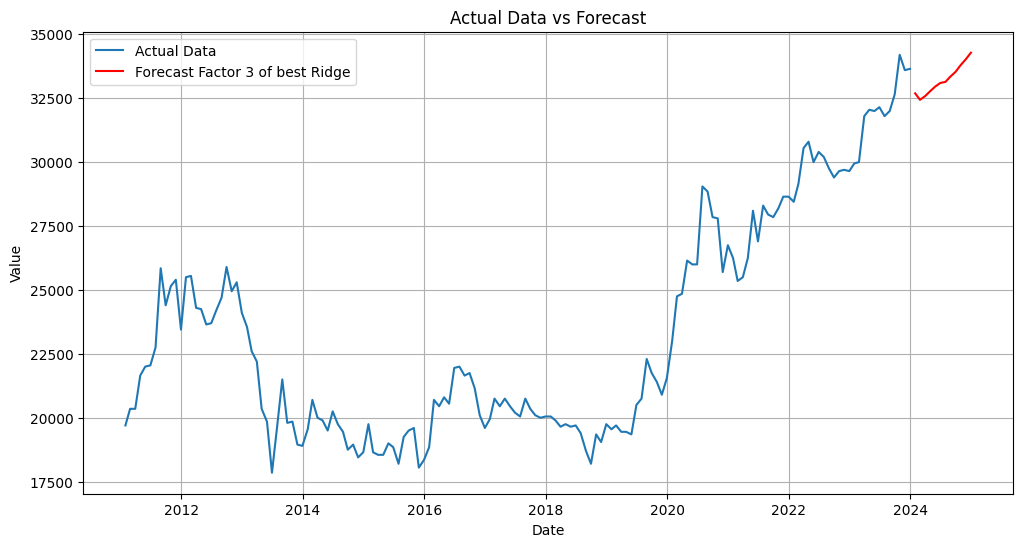

In [386]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_ridge), label='Forecast Factor 3 of best Ridge' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [389]:
np.exp(y_pred_ridge)

array([[32692.03167493],
       [32438.7198329 ],
       [32584.67201939],
       [32773.91428125],
       [32959.52758816],
       [33097.88890908],
       [33140.45803236],
       [33355.15051625],
       [33534.34887564],
       [33800.32381183],
       [34021.38388601],
       [34281.12324828]])

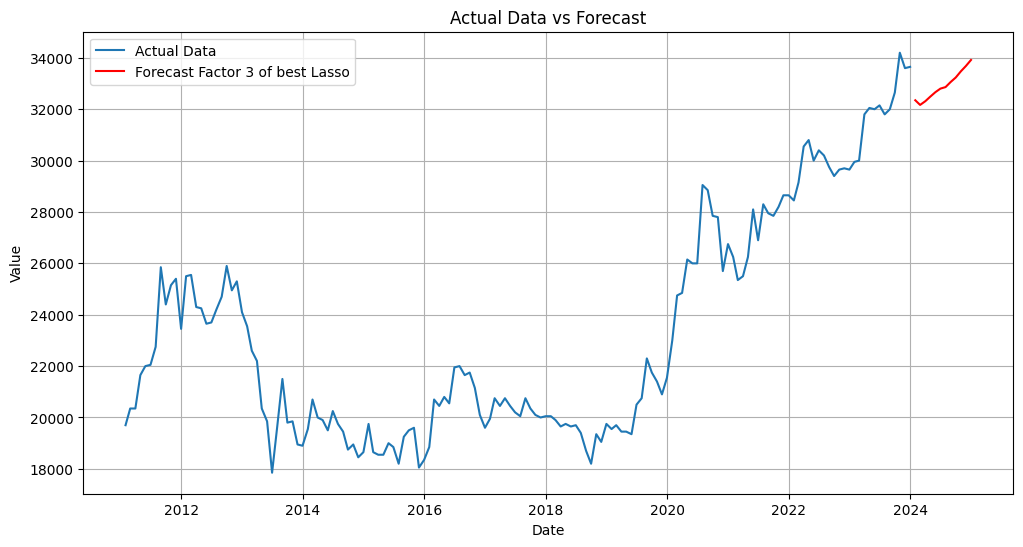

In [391]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_lasso), label='Forecast Factor 3 of best Lasso' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [388]:
np.exp(y_pred_lasso)

array([32349.16996912, 32168.02079046, 32311.00428556, 32489.35270663,
       32664.96175757, 32802.43364269, 32862.35483089, 33062.25078353,
       33233.5463658 , 33475.46900172, 33681.15103258, 33918.39252473])

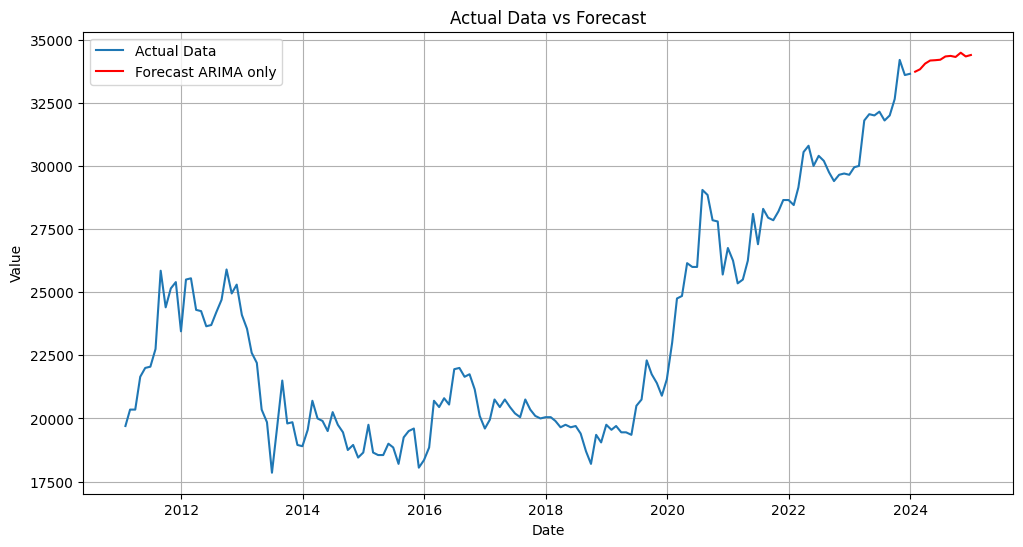

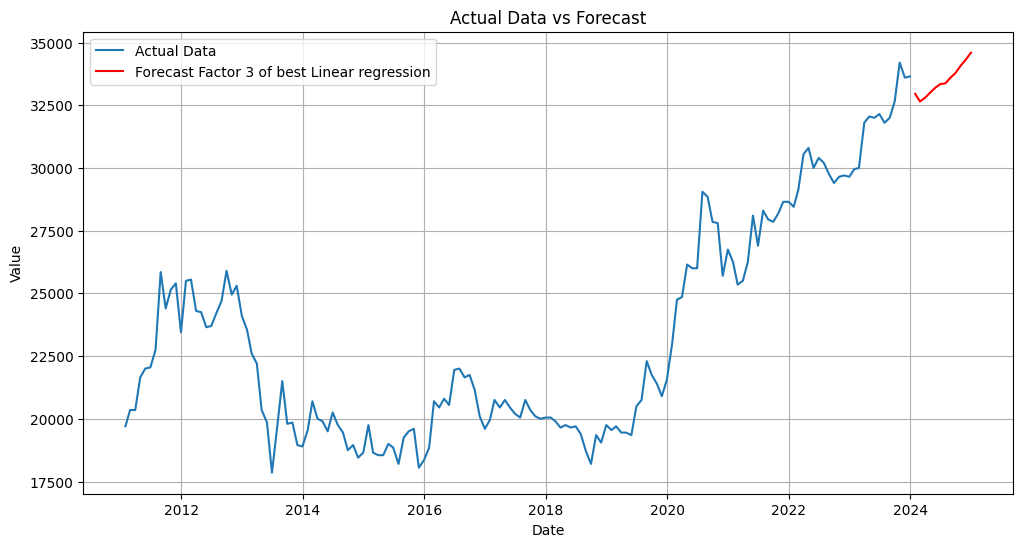

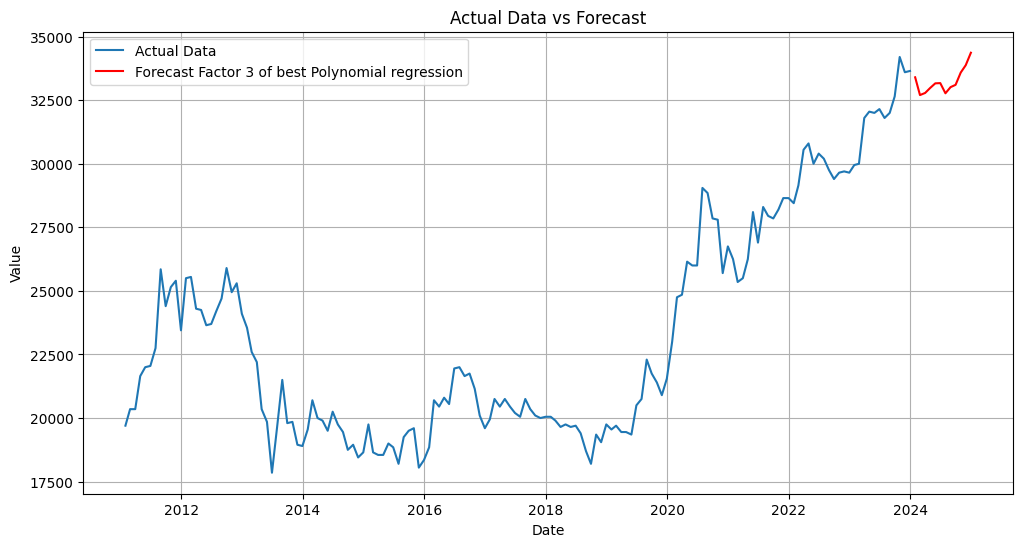

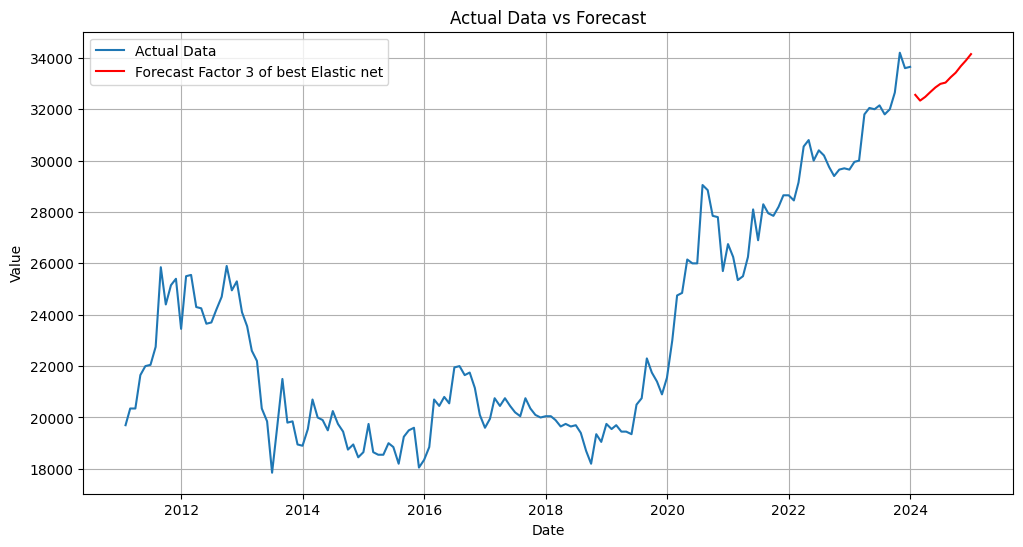

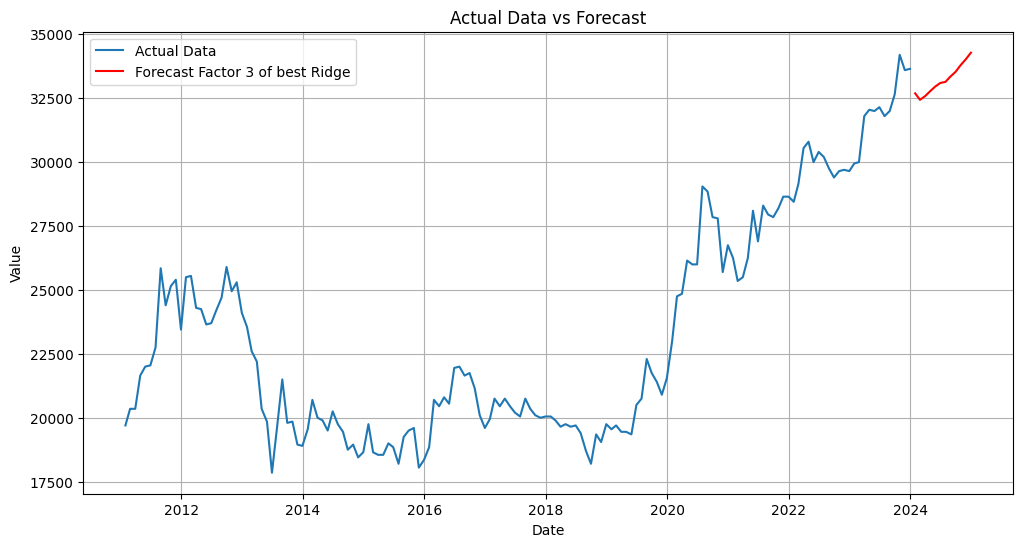

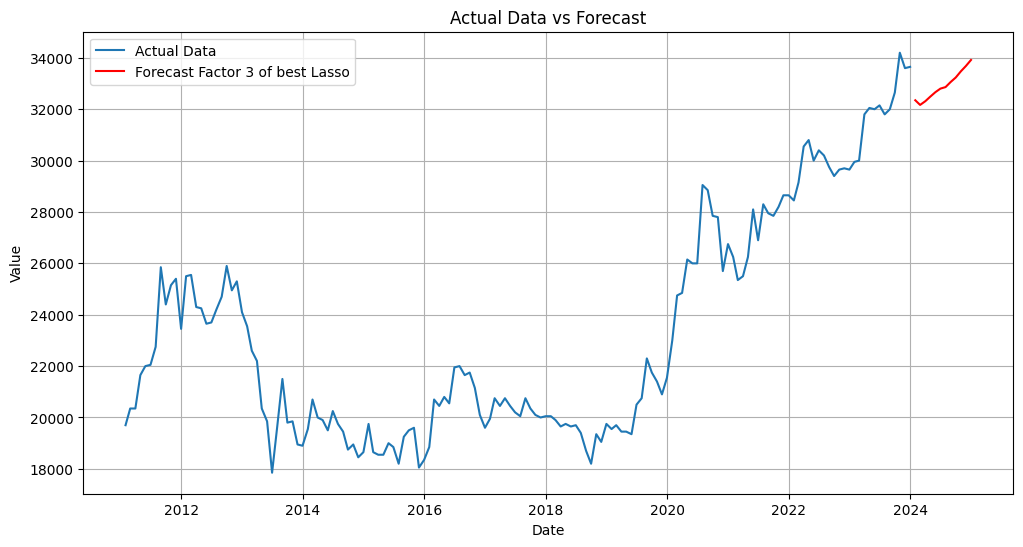

In [392]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,arima_only_predict, label='Forecast ARIMA only' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_linear), label='Forecast Factor 3 of best Linear regression' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(Predict_Poly), label='Forecast Factor 3 of best Polynomial regression' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_elastic_net), label='Forecast Factor 3 of best Elastic net' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_ridge), label='Forecast Factor 3 of best Ridge' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_lasso), label='Forecast Factor 3 of best Lasso' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

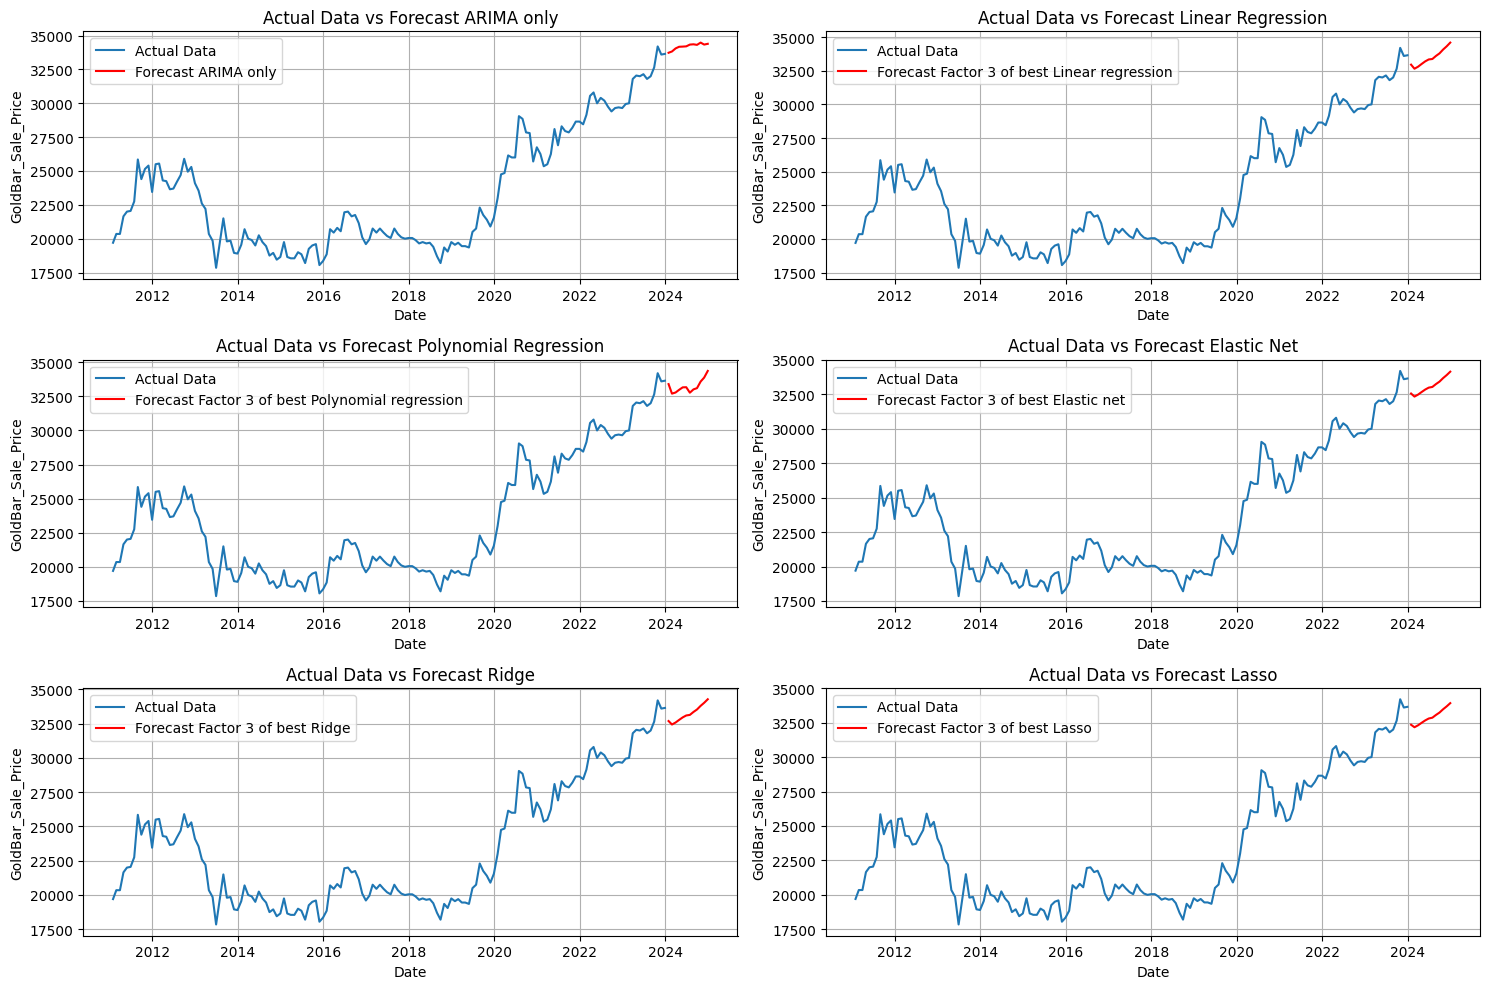

In [398]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(3, 2, figsize=(15, 10))  # สร้างพื้นที่สำหรับ subplot 3 แถว 2 คอลัมน์
y_tag_label = 'GoldBar_Sale_Price'
# กราฟที่ 1: ARIMA
axs[0, 0].plot(Gold_data['Report Date'], Gold_data['GoldBar_Sale'], label='Actual Data')
axs[0, 0].plot(Date_forecast_period, arima_only_predict, label='Forecast ARIMA only', color='red')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel(y_tag_label)
axs[0, 0].set_title('Actual Data vs Forecast ARIMA only')
axs[0, 0].legend()
axs[0, 0].grid(True)

# กราฟที่ 2: Linear Regression
axs[0, 1].plot(Gold_data['Report Date'], Gold_data['GoldBar_Sale'], label='Actual Data')
axs[0, 1].plot(Date_forecast_period, np.exp(y_pred_linear), label='Forecast Factor 3 of best Linear regression', color='red')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel(y_tag_label)
axs[0, 1].set_title('Actual Data vs Forecast Linear Regression')
axs[0, 1].legend()
axs[0, 1].grid(True)

# กราฟที่ 3: Polynomial Regression
axs[1, 0].plot(Gold_data['Report Date'], Gold_data['GoldBar_Sale'], label='Actual Data')
axs[1, 0].plot(Date_forecast_period, np.exp(Predict_Poly), label='Forecast Factor 3 of best Polynomial regression', color='red')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel(y_tag_label)
axs[1, 0].set_title('Actual Data vs Forecast Polynomial Regression')
axs[1, 0].legend()
axs[1, 0].grid(True)

# กราฟที่ 4: Elastic Net
axs[1, 1].plot(Gold_data['Report Date'], Gold_data['GoldBar_Sale'], label='Actual Data')
axs[1, 1].plot(Date_forecast_period, np.exp(y_pred_elastic_net), label='Forecast Factor 3 of best Elastic net', color='red')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel(y_tag_label)
axs[1, 1].set_title('Actual Data vs Forecast Elastic Net')
axs[1, 1].legend()
axs[1, 1].grid(True)

# กราฟที่ 5: Ridge
axs[2, 0].plot(Gold_data['Report Date'], Gold_data['GoldBar_Sale'], label='Actual Data')
axs[2, 0].plot(Date_forecast_period, np.exp(y_pred_ridge), label='Forecast Factor 3 of best Ridge', color='red')
axs[2, 0].set_xlabel('Date')
axs[2, 0].set_ylabel(y_tag_label)
axs[2, 0].set_title('Actual Data vs Forecast Ridge')
axs[2, 0].legend()
axs[2, 0].grid(True)

# กราฟที่ 6: Lasso
axs[2, 1].plot(Gold_data['Report Date'], Gold_data['GoldBar_Sale'], label='Actual Data')
axs[2, 1].plot(Date_forecast_period, np.exp(y_pred_lasso), label='Forecast Factor 3 of best Lasso', color='red')
axs[2, 1].set_xlabel('Date')
axs[2, 1].set_ylabel(y_tag_label)
axs[2, 1].set_title('Actual Data vs Forecast Lasso')
axs[2, 1].legend()
axs[2, 1].grid(True)

plt.tight_layout()
plt.show()
